In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, cifar_noniid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img


import math


# from sympy import * 
from utils.functions import *

%load_ext autoreload
%autoreload 2

In [2]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 120  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=100 #"local batch size: B"
    bs=100 #"test batch size"
    lr=0.03 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'SGD' #'ADAM'
    loss = 'Cross'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=0
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


In [4]:
# load dataset and split users

from torchvision import datasets, transforms

if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        dict_users = cifar_noniid(dataset_train, args.num_users)
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

c:\programdata\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
histo_ = np.zeros((10,))

for i in range(args.num_users):
    idxs=dict_users[i].astype(int)
    target = np.array(dataset_train.targets)
    cur_labels = target[idxs]
#     print(np.shape(target))
#     print(target[idxs])
    
    label_first = cur_labels[0]
    label_second = cur_labels[-1]
    
    print(i,'-th user label = ',label_first,label_second)
    histo_[label_first] += 1
    histo_[label_second] += 1
    print(cur_labels)

print(histo_)

0 -th user label =  1 8
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 

# 1. Symmetric Dropout Probability

Dropout probability of each class follows the same distribution, i.e., Uniform{0.1, 0.2, 0.3, 0.4, 0.5}

In [42]:
N = args.num_users

p_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

# print(p_matrix)
p_sel = np.random.randint(low=0, high=len(p_array), size=(N,))

p_per_user = np.ones((N,))

for i in range(N):
    p_per_user[i] = p_array[p_sel[i]]

print(p_per_user)


histo__ = np.zeros((len(p_array),10))

for i in range(N):
    idxs=dict_users[i].astype(int)
    target = np.array(dataset_train.targets)
    cur_labels = target[idxs]
#     print(np.shape(target))
#     print(target[idxs])
    
    label_first = cur_labels[0]
    label_second = cur_labels[-1]
    
    p_idx = p_per_user[i]*10
    p_idx = int(p_idx-1)
    
    histo__[p_idx][label_first] += 1
    histo__[p_idx][label_second] += 1
    
print(histo__[0,:])
print(histo__[1,:])
print(histo__[2,:])
print(histo__[3,:])
print(histo__[4,:])

tmp = histo__[0,:] * 0.9 + histo__[1,:] * 0.8 + histo__[2,:] * 0.7 + histo__[3,:] * 0.6 + histo__[4,:] * 0.5
print(tmp)

[0.4 0.4 0.2 0.3 0.2 0.5 0.2 0.3 0.4 0.5 0.2 0.1 0.5 0.5 0.1 0.2 0.5 0.5
 0.3 0.3 0.3 0.2 0.5 0.5 0.5 0.2 0.3 0.4 0.1 0.2 0.4 0.3 0.5 0.5 0.4 0.4
 0.1 0.2 0.3 0.2 0.4 0.3 0.5 0.5 0.4 0.4 0.3 0.4 0.4 0.2 0.1 0.2 0.1 0.5
 0.5 0.4 0.4 0.5 0.4 0.3 0.5 0.3 0.4 0.2 0.5 0.5 0.1 0.3 0.5 0.3 0.1 0.4
 0.5 0.4 0.5 0.1 0.3 0.5 0.5 0.5 0.2 0.2 0.3 0.5 0.5 0.4 0.2 0.4 0.4 0.4
 0.5 0.1 0.4 0.5 0.3 0.3 0.2 0.5 0.4 0.4 0.4 0.3 0.3 0.1 0.3 0.3 0.2 0.4
 0.1 0.4 0.3 0.4 0.5 0.4 0.2 0.2 0.4 0.1 0.3 0.3]
[3. 6. 3. 2. 3. 1. 3. 3. 1. 1.]
[2. 8. 5. 4. 5. 2. 3. 5. 3. 3.]
[3. 3. 5. 7. 4. 5. 6. 4. 6. 7.]
[11.  6.  4.  8.  6.  8.  2.  4.  5.  8.]
[ 4.  5.  6.  5.  5.  5.  9. 10.  8.  5.]
[15.  20.  15.6 17.2 15.6 13.3 15.  16.9 14.5 15.5]


In [43]:
p = 0
N = 120
K = 12

N_trials = 1
Max_iter = 500

lr_array = [0.03]

acc_test_arr  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr = np.zeros((len(lr_array), N_trials, Max_iter))



P_random = []

for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist2(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
#             u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)


        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.2968 
Accuracy: 1400/10000 (14.00%)

Round   0, Train average loss 2.358 Test accuracy 14.000

Test set: Average loss: 2.2662 
Accuracy: 1435/10000 (14.35%)

Round   1, Train average loss 2.040 Test accuracy 14.350

Test set: Average loss: 2.1987 
Accuracy: 3223/10000 (32.23%)

Round   2, Train average loss 1.987 Test accuracy 32.230

Test set: Average loss: 2.1300 
Accuracy: 2854/10000 (28.54%)

Round   3, Train average loss 1.877 Test accuracy 28.540

Test set: Average loss: 2.0622 
Accuracy: 2713/10000 (27.13%)

Round   4, Train average loss 1.672 Test accuracy 27.130

Test set: Average loss: 1.9342 
Accuracy: 4145/10000 (41.45%)

Round   5, Train average loss 1.603 Test accuracy 41.450

Test set: Average loss: 1.7542 
Accuracy: 6885/10000 (


Test set: Average loss: 0.1612 
Accuracy: 9465/10000 (94.65%)

Round  66, Train average loss 0.109 Test accuracy 94.650

Test set: Average loss: 0.1597 
Accuracy: 9481/10000 (94.81%)

Round  67, Train average loss 0.079 Test accuracy 94.810

Test set: Average loss: 0.1366 
Accuracy: 9598/10000 (95.98%)

Round  68, Train average loss 0.117 Test accuracy 95.980

Test set: Average loss: 0.1393 
Accuracy: 9596/10000 (95.96%)

Round  69, Train average loss 0.086 Test accuracy 95.960

Test set: Average loss: 0.1363 
Accuracy: 9589/10000 (95.89%)

Round  70, Train average loss 0.074 Test accuracy 95.890

Test set: Average loss: 0.1378 
Accuracy: 9549/10000 (95.49%)

Round  71, Train average loss 0.093 Test accuracy 95.490

Test set: Average loss: 0.1363 
Accuracy: 9576/10000 (95.76%)

Round  72, Train average loss 0.088 Test accuracy 95.760

Test set: Average loss: 0.1260 
Accuracy: 9618/10000 (96.18%)

Round  73, Train average loss 0.094 Test accuracy 96.180

Test set: Average loss: 0.1309 


Test set: Average loss: 0.0925 
Accuracy: 9716/10000 (97.16%)

Round 134, Train average loss 0.071 Test accuracy 97.160

Test set: Average loss: 0.0847 
Accuracy: 9741/10000 (97.41%)

Round 135, Train average loss 0.069 Test accuracy 97.410

Test set: Average loss: 0.0811 
Accuracy: 9749/10000 (97.49%)

Round 136, Train average loss 0.052 Test accuracy 97.490

Test set: Average loss: 0.0866 
Accuracy: 9727/10000 (97.27%)

Round 137, Train average loss 0.060 Test accuracy 97.270

Test set: Average loss: 0.0863 
Accuracy: 9727/10000 (97.27%)

Round 138, Train average loss 0.056 Test accuracy 97.270

Test set: Average loss: 0.0928 
Accuracy: 9724/10000 (97.24%)

Round 139, Train average loss 0.051 Test accuracy 97.240

Test set: Average loss: 0.0942 
Accuracy: 9689/10000 (96.89%)

Round 140, Train average loss 0.066 Test accuracy 96.890

Test set: Average loss: 0.0795 
Accuracy: 9757/10000 (97.57%)

Round 141, Train average loss 0.066 Test accuracy 97.570

Test set: Average loss: 0.0873 


Test set: Average loss: 0.0633 
Accuracy: 9810/10000 (98.10%)

Round 202, Train average loss 0.048 Test accuracy 98.100

Test set: Average loss: 0.0651 
Accuracy: 9799/10000 (97.99%)

Round 203, Train average loss 0.053 Test accuracy 97.990

Test set: Average loss: 0.0666 
Accuracy: 9796/10000 (97.96%)

Round 204, Train average loss 0.046 Test accuracy 97.960

Test set: Average loss: 0.0692 
Accuracy: 9792/10000 (97.92%)

Round 205, Train average loss 0.046 Test accuracy 97.920

Test set: Average loss: 0.0636 
Accuracy: 9807/10000 (98.07%)

Round 206, Train average loss 0.050 Test accuracy 98.070

Test set: Average loss: 0.0640 
Accuracy: 9800/10000 (98.00%)

Round 207, Train average loss 0.045 Test accuracy 98.000

Test set: Average loss: 0.0664 
Accuracy: 9800/10000 (98.00%)

Round 208, Train average loss 0.045 Test accuracy 98.000

Test set: Average loss: 0.0772 
Accuracy: 9769/10000 (97.69%)

Round 209, Train average loss 0.047 Test accuracy 97.690

Test set: Average loss: 0.0694 


Test set: Average loss: 0.0539 
Accuracy: 9830/10000 (98.30%)

Round 270, Train average loss 0.041 Test accuracy 98.300

Test set: Average loss: 0.0545 
Accuracy: 9836/10000 (98.36%)

Round 271, Train average loss 0.034 Test accuracy 98.360

Test set: Average loss: 0.0574 
Accuracy: 9831/10000 (98.31%)

Round 272, Train average loss 0.034 Test accuracy 98.310

Test set: Average loss: 0.0600 
Accuracy: 9815/10000 (98.15%)

Round 273, Train average loss 0.042 Test accuracy 98.150

Test set: Average loss: 0.0587 
Accuracy: 9822/10000 (98.22%)

Round 274, Train average loss 0.035 Test accuracy 98.220

Test set: Average loss: 0.0523 
Accuracy: 9844/10000 (98.44%)

Round 275, Train average loss 0.037 Test accuracy 98.440

Test set: Average loss: 0.0549 
Accuracy: 9836/10000 (98.36%)

Round 276, Train average loss 0.047 Test accuracy 98.360

Test set: Average loss: 0.0615 
Accuracy: 9815/10000 (98.15%)

Round 277, Train average loss 0.035 Test accuracy 98.150

Test set: Average loss: 0.0642 


Test set: Average loss: 0.0532 
Accuracy: 9831/10000 (98.31%)

Round 338, Train average loss 0.031 Test accuracy 98.310

Test set: Average loss: 0.0472 
Accuracy: 9861/10000 (98.61%)

Round 339, Train average loss 0.033 Test accuracy 98.610

Test set: Average loss: 0.0511 
Accuracy: 9842/10000 (98.42%)

Round 340, Train average loss 0.036 Test accuracy 98.420

Test set: Average loss: 0.0509 
Accuracy: 9847/10000 (98.47%)

Round 341, Train average loss 0.029 Test accuracy 98.470

Test set: Average loss: 0.0479 
Accuracy: 9860/10000 (98.60%)

Round 342, Train average loss 0.032 Test accuracy 98.600

Test set: Average loss: 0.0510 
Accuracy: 9846/10000 (98.46%)

Round 343, Train average loss 0.029 Test accuracy 98.460

Test set: Average loss: 0.0486 
Accuracy: 9857/10000 (98.57%)

Round 344, Train average loss 0.027 Test accuracy 98.570

Test set: Average loss: 0.0500 
Accuracy: 9846/10000 (98.46%)

Round 345, Train average loss 0.033 Test accuracy 98.460

Test set: Average loss: 0.0484 


Test set: Average loss: 0.0466 
Accuracy: 9845/10000 (98.45%)

Round 406, Train average loss 0.032 Test accuracy 98.450

Test set: Average loss: 0.0449 
Accuracy: 9853/10000 (98.53%)

Round 407, Train average loss 0.027 Test accuracy 98.530

Test set: Average loss: 0.0451 
Accuracy: 9868/10000 (98.68%)

Round 408, Train average loss 0.039 Test accuracy 98.680

Test set: Average loss: 0.0457 
Accuracy: 9859/10000 (98.59%)

Round 409, Train average loss 0.026 Test accuracy 98.590

Test set: Average loss: 0.0451 
Accuracy: 9863/10000 (98.63%)

Round 410, Train average loss 0.029 Test accuracy 98.630

Test set: Average loss: 0.0436 
Accuracy: 9872/10000 (98.72%)

Round 411, Train average loss 0.031 Test accuracy 98.720

Test set: Average loss: 0.0468 
Accuracy: 9851/10000 (98.51%)

Round 412, Train average loss 0.029 Test accuracy 98.510

Test set: Average loss: 0.0472 
Accuracy: 9849/10000 (98.49%)

Round 413, Train average loss 0.030 Test accuracy 98.490

Test set: Average loss: 0.0455 


Test set: Average loss: 0.0432 
Accuracy: 9867/10000 (98.67%)

Round 474, Train average loss 0.030 Test accuracy 98.670

Test set: Average loss: 0.0489 
Accuracy: 9840/10000 (98.40%)

Round 475, Train average loss 0.031 Test accuracy 98.400

Test set: Average loss: 0.0421 
Accuracy: 9873/10000 (98.73%)

Round 476, Train average loss 0.029 Test accuracy 98.730

Test set: Average loss: 0.0422 
Accuracy: 9872/10000 (98.72%)

Round 477, Train average loss 0.027 Test accuracy 98.720

Test set: Average loss: 0.0460 
Accuracy: 9851/10000 (98.51%)

Round 478, Train average loss 0.030 Test accuracy 98.510

Test set: Average loss: 0.0448 
Accuracy: 9848/10000 (98.48%)

Round 479, Train average loss 0.026 Test accuracy 98.480

Test set: Average loss: 0.0416 
Accuracy: 9878/10000 (98.78%)

Round 480, Train average loss 0.033 Test accuracy 98.780

Test set: Average loss: 0.0442 
Accuracy: 9864/10000 (98.64%)

Round 481, Train average loss 0.026 Test accuracy 98.640

Test set: Average loss: 0.0478 

# 1.2. Partition

In [32]:
N   = 120
K   = 12

Codebook_Proposed_T6 = CodeBookDesign_Bin(N,K,6)
Codebook_Proposed_T4 = CodeBookDesign_Bin(N,K,4)
Codebook_Proposed_T3 = CodeBookDesign_Bin(N,K,3)

Codebook_Partition = CodeBookDesign_Partition(N,K)

# print(Codebook_Partition)

@CodeBookDesign_Bin, Codebook Size= 190
@CodeBookDesign_Bin, Codebook Size= 4060
@CodeBookDesign_Bin, Codebook Size= 91389
@CodeBookDesign_Partition, Codebook Size= 10


In [44]:
p = 0.3

args.lr = 0.03
Max_iter = 500

net_glob = CNNMnist2(args)
net_glob = net_glob.cuda()
print(net_glob)

net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_test_arr_partition = []
acc_test_arr_partition = []


P_partition = []
is_selection_applied = True
is_print = True

for iter in range(Max_iter): #args.epochs
    w_locals, loss_locals = [], []
    
    u = np.ones((N,))
    for u_idx in range(N):
        p_sel = p_per_user[u_idx]
        u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

    result = np.where(u == 1)
    
    tmp = Codebook_Partition * u
    
    codebook_en = 1*(np.sum(tmp,axis=1) == K)

    if np.sum(codebook_en) == 0:
        if is_print:
            print('[iter=',iter,'] @Partition Method, there is no available codebook')
        p_tmp = np.zeros(N)
    else:
        if is_print:
            print('[iter=',iter,'] @Partition Method, Codebook selection')
        idx_en = np.where(codebook_en == 1)

        if is_selection_applied:
            codebook_en_num = np.sum(codebook_en)
            Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))

            p_tmp = UserSelection_Codebook(P_partition, Codebook_En)
        else:
            idx_sel = np.random.choice(idx_en[0], 1, replace=False)
            p_tmp = Codebook_Partition[idx_sel[0],:]

#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]
    
    idxs_users = np.where(p_tmp == 1)
    
    P_partition.append(p_tmp)
    
#     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

    if np.sum(p_tmp) == K:
        for idx in idxs_users[0]:
            print('selected idx=',idx)
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
            w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
            w_locals.append(copy.deepcopy(w))
            loss_locals.append(copy.deepcopy(loss))
        # update global weights
        w_glob = FedAvg(w_locals)

        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
        loss_avg = sum(loss_locals) / len(loss_locals)

#         loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr_partition.append(acc_test)
    loss_test_arr_partition.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Partition Method, there is no available codebook

Test set: Average loss: 2.2836 
Accuracy: 1909/10000 (19.09%)

Round   0, Train average loss 0.024 Test accuracy 19.090
[iter= 1 ] @Partition Method, there is no available codebook

Test set: Average loss: 2.2836 
Accuracy: 1909/10000 (19.09%)

Round   1, Train average loss 0.024 Test accuracy 19.090
[iter= 2 ] @Partition Method, there is no available codebook

Test set: Average loss: 2.2836 
Accuracy: 1909/10000 (19.09%)

Round   2, Train average loss 0.024 Test accuracy 19.090
[iter= 3 ] @Partition Method, there is no available codebook

Test set: Average loss: 2.2836 
Accuracy: 1909/10000 (19.09%)

Round   3, Train average loss 0.024 Test accuracy 19.090
[iter= 4 ] @Partition Method, there is no available codebook

Test set: Aver


Test set: Average loss: 2.2599 
Accuracy: 3258/10000 (32.58%)

Round  43, Train average loss 2.070 Test accuracy 32.580
[iter= 44 ] @Partition Method, there is no available codebook

Test set: Average loss: 2.2599 
Accuracy: 3258/10000 (32.58%)

Round  44, Train average loss 2.070 Test accuracy 32.580
[iter= 45 ] @Partition Method, there is no available codebook

Test set: Average loss: 2.2599 
Accuracy: 3258/10000 (32.58%)

Round  45, Train average loss 2.070 Test accuracy 32.580
[iter= 46 ] @Partition Method, there is no available codebook

Test set: Average loss: 2.2599 
Accuracy: 3258/10000 (32.58%)

Round  46, Train average loss 2.070 Test accuracy 32.580
[iter= 47 ] @Partition Method, there is no available codebook

Test set: Average loss: 2.2599 
Accuracy: 3258/10000 (32.58%)

Round  47, Train average loss 2.070 Test accuracy 32.580
[iter= 48 ] @Partition Method, Codebook selection
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selecte


Test set: Average loss: 1.9389 
Accuracy: 4532/10000 (45.32%)

Round  85, Train average loss 1.378 Test accuracy 45.320
[iter= 86 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.9389 
Accuracy: 4532/10000 (45.32%)

Round  86, Train average loss 1.378 Test accuracy 45.320
[iter= 87 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.9389 
Accuracy: 4532/10000 (45.32%)

Round  87, Train average loss 1.378 Test accuracy 45.320
[iter= 88 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.9389 
Accuracy: 4532/10000 (45.32%)

Round  88, Train average loss 1.378 Test accuracy 45.320
[iter= 89 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.9389 
Accuracy: 4532/10000 (45.32%)

Round  89, Train average loss 1.378 Test accuracy 45.320
[iter= 90 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.9389 
Accuracy: 4532/10000 (45.32%)

Round  90, Train aver


Test set: Average loss: 1.5357 
Accuracy: 5238/10000 (52.38%)

Round 128, Train average loss 0.914 Test accuracy 52.380
[iter= 129 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.5357 
Accuracy: 5238/10000 (52.38%)

Round 129, Train average loss 0.914 Test accuracy 52.380
[iter= 130 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.5357 
Accuracy: 5238/10000 (52.38%)

Round 130, Train average loss 0.914 Test accuracy 52.380
[iter= 131 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.5357 
Accuracy: 5238/10000 (52.38%)

Round 131, Train average loss 0.914 Test accuracy 52.380
[iter= 132 ] @Partition Method, Codebook selection
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.4469 
Accuracy: 6535/10000 (65.35


Test set: Average loss: 1.4469 
Accuracy: 6535/10000 (65.35%)

Round 172, Train average loss 0.854 Test accuracy 65.350
[iter= 173 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.4469 
Accuracy: 6535/10000 (65.35%)

Round 173, Train average loss 0.854 Test accuracy 65.350
[iter= 174 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.4469 
Accuracy: 6535/10000 (65.35%)

Round 174, Train average loss 0.854 Test accuracy 65.350
[iter= 175 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.4469 
Accuracy: 6535/10000 (65.35%)

Round 175, Train average loss 0.854 Test accuracy 65.350
[iter= 176 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.4469 
Accuracy: 6535/10000 (65.35%)

Round 176, Train average loss 0.854 Test accuracy 65.350
[iter= 177 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.4469 
Accuracy: 6535/10000 (65.35%)

Round 177, Train


Test set: Average loss: 1.1103 
Accuracy: 6817/10000 (68.17%)

Round 215, Train average loss 0.558 Test accuracy 68.170
[iter= 216 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.1103 
Accuracy: 6817/10000 (68.17%)

Round 216, Train average loss 0.558 Test accuracy 68.170
[iter= 217 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.1103 
Accuracy: 6817/10000 (68.17%)

Round 217, Train average loss 0.558 Test accuracy 68.170
[iter= 218 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.1103 
Accuracy: 6817/10000 (68.17%)

Round 218, Train average loss 0.558 Test accuracy 68.170
[iter= 219 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.1103 
Accuracy: 6817/10000 (68.17%)

Round 219, Train average loss 0.558 Test accuracy 68.170
[iter= 220 ] @Partition Method, there is no available codebook

Test set: Average loss: 1.1103 
Accuracy: 6817/10000 (68.17%)

Round 220, Train


Test set: Average loss: 0.8761 
Accuracy: 7762/10000 (77.62%)

Round 258, Train average loss 0.531 Test accuracy 77.620
[iter= 259 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.8761 
Accuracy: 7762/10000 (77.62%)

Round 259, Train average loss 0.531 Test accuracy 77.620
[iter= 260 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.8761 
Accuracy: 7762/10000 (77.62%)

Round 260, Train average loss 0.531 Test accuracy 77.620
[iter= 261 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.8761 
Accuracy: 7762/10000 (77.62%)

Round 261, Train average loss 0.531 Test accuracy 77.620
[iter= 262 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.8761 
Accuracy: 7762/10000 (77.62%)

Round 262, Train average loss 0.531 Test accuracy 77.620
[iter= 263 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.8761 
Accuracy: 7762/10000 (77.62%)

Round 263, Train


Test set: Average loss: 0.5391 
Accuracy: 8607/10000 (86.07%)

Round 299, Train average loss 0.336 Test accuracy 86.070
[iter= 300 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.5391 
Accuracy: 8607/10000 (86.07%)

Round 300, Train average loss 0.336 Test accuracy 86.070
[iter= 301 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.5391 
Accuracy: 8607/10000 (86.07%)

Round 301, Train average loss 0.336 Test accuracy 86.070
[iter= 302 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.5391 
Accuracy: 8607/10000 (86.07%)

Round 302, Train average loss 0.336 Test accuracy 86.070
[iter= 303 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.5391 
Accuracy: 8607/10000 (86.07%)

Round 303, Train average loss 0.336 Test accuracy 86.070
[iter= 304 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.5391 
Accuracy: 8607/10000 (86.07%)

Round 304, Train


Test set: Average loss: 0.4445 
Accuracy: 8838/10000 (88.38%)

Round 342, Train average loss 0.255 Test accuracy 88.380
[iter= 343 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.4445 
Accuracy: 8838/10000 (88.38%)

Round 343, Train average loss 0.255 Test accuracy 88.380
[iter= 344 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.4445 
Accuracy: 8838/10000 (88.38%)

Round 344, Train average loss 0.255 Test accuracy 88.380
[iter= 345 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.4445 
Accuracy: 8838/10000 (88.38%)

Round 345, Train average loss 0.255 Test accuracy 88.380
[iter= 346 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.4445 
Accuracy: 8838/10000 (88.38%)

Round 346, Train average loss 0.255 Test accuracy 88.380
[iter= 347 ] @Partition Method, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selecte


Test set: Average loss: 0.3844 
Accuracy: 8987/10000 (89.87%)

Round 383, Train average loss 0.219 Test accuracy 89.870
[iter= 384 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.3844 
Accuracy: 8987/10000 (89.87%)

Round 384, Train average loss 0.219 Test accuracy 89.870
[iter= 385 ] @Partition Method, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.3463 
Accuracy: 9048/10000 (90.48%)

Round 385, Train average loss 0.248 Test accuracy 90.480
[iter= 386 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.3463 
Accuracy: 9048/10000 (90.48%)

Round 386, Train average loss 0.248 Test accuracy 90.480
[iter= 387 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.3463 
Accuracy: 9048/10000 (90.48%)




Test set: Average loss: 0.3119 
Accuracy: 9155/10000 (91.55%)

Round 425, Train average loss 0.193 Test accuracy 91.550
[iter= 426 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.3119 
Accuracy: 9155/10000 (91.55%)

Round 426, Train average loss 0.193 Test accuracy 91.550
[iter= 427 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.3119 
Accuracy: 9155/10000 (91.55%)

Round 427, Train average loss 0.193 Test accuracy 91.550
[iter= 428 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.3119 
Accuracy: 9155/10000 (91.55%)

Round 428, Train average loss 0.193 Test accuracy 91.550
[iter= 429 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.3119 
Accuracy: 9155/10000 (91.55%)

Round 429, Train average loss 0.193 Test accuracy 91.550
[iter= 430 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.3119 
Accuracy: 9155/10000 (91.55%)

Round 430, Train


Test set: Average loss: 0.2873 
Accuracy: 9232/10000 (92.32%)

Round 465, Train average loss 0.195 Test accuracy 92.320
[iter= 466 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.2873 
Accuracy: 9232/10000 (92.32%)

Round 466, Train average loss 0.195 Test accuracy 92.320
[iter= 467 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.2873 
Accuracy: 9232/10000 (92.32%)

Round 467, Train average loss 0.195 Test accuracy 92.320
[iter= 468 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.2873 
Accuracy: 9232/10000 (92.32%)

Round 468, Train average loss 0.195 Test accuracy 92.320
[iter= 469 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.2873 
Accuracy: 9232/10000 (92.32%)

Round 469, Train average loss 0.195 Test accuracy 92.320
[iter= 470 ] @Partition Method, there is no available codebook

Test set: Average loss: 0.2873 
Accuracy: 9232/10000 (92.32%)

Round 470, Train

In [46]:
args.lr = 0.03
Max_iter = 500
# training
loss_test_arr_Proposed_N120_K12_T6 = []
acc_test_arr_Proposed_N120_K12_T6 = []

P_proposed_T6 = []
is_selection_applied = True
is_print = True



net_glob = CNNMnist2(args)
net_glob = net_glob.cuda()
print(net_glob)

net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

for iter in range(Max_iter): #args.epochs
    w_locals, loss_locals = [], []
    
#     u = np.random.binomial(1, 1-p, size=(N))
    u = np.ones((N,))
    for u_idx in range(N):
        p_sel = p_per_user[u_idx]
        u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
    
    tmp = Codebook_Proposed_T6 * u
    
    codebook_en = 1*(np.sum(tmp,axis=1) == K)

    if np.sum(codebook_en) == 0:
        if is_print:
            print('[iter=',iter,'] @Proposed T=6, there is no available codebook')
        p_tmp = np.zeros(N)
    else:
        if is_print:
            print('[iter=',iter,'] @Proposed T=6, Codebook selection')
        idx_en = np.where(codebook_en == 1)

        if is_selection_applied:
            codebook_en_num = np.sum(codebook_en)
            Codebook_En = np.reshape(Codebook_Proposed_T6[idx_en,:],(codebook_en_num,N))

            p_tmp = UserSelection_Codebook(P_proposed_T6, Codebook_En)
        else:
            idx_sel = np.random.choice(idx_en[0], 1, replace=False)
            p_tmp = Codebook_Proposed_T6[idx_sel[0],:]

#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]
    
    idxs_users = np.where(p_tmp == 1)
    
    P_proposed_T6.append(p_tmp)
    
#     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

    if np.sum(p_tmp) == K:
        for idx in idxs_users[0]:
            print('selected idx=',idx)
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
            w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
            w_locals.append(copy.deepcopy(w))
            loss_locals.append(copy.deepcopy(loss))
        # update global weights
        w_glob = FedAvg(w_locals)

        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
        loss_avg = sum(loss_locals) / len(loss_locals)

#         loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr_Proposed_N120_K12_T6.append(acc_test)
    loss_test_arr_Proposed_N120_K12_T6.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 2.3120 
Accuracy: 840/10000 (8.40%)

Round   0, Train average loss 2.347 Test accuracy 8.400
[iter= 1 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 2.3120 
Accuracy: 840/10000 (8.40%)

Round   1, Train average loss 2.347 Test accuracy 8.400
[iter= 2 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 2.3120 
Accuracy: 840/10000 (8.40%)

Round   2, Train average loss 2.347 Test accuracy 8.400
[iter= 3 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss:

selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53

Test set: Average loss: 0.7860 
Accuracy: 7753/10000 (77.53%)

Round  29, Train average loss 0.446 Test accuracy 77.530
[iter= 30 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.6983 
Accuracy: 8089/10000 (80.89%)

Round  30, Train average loss 0.469 Test accuracy 80.890
[iter= 31 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.6983 
Accuracy: 8089/10000 (80.89%)

Round  31, Train average loss 0.469 Test accuracy 80.890
[iter= 32 ] @Proposed T=6, Codebook selection
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx


Test set: Average loss: 0.3242 
Accuracy: 9136/10000 (91.36%)

Round  58, Train average loss 0.222 Test accuracy 91.360
[iter= 59 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.3044 
Accuracy: 9175/10000 (91.75%)

Round  59, Train average loss 0.210 Test accuracy 91.750
[iter= 60 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.3044 
Accuracy: 9175/10000 (91.75%)

Round  60, Train average loss 0.210 Test accuracy 91.750
[iter= 61 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.3044 
Accuracy: 9175/10000 (91.75%)

Round  61, Train average loss 0.210 Test accuracy 91.750
[iter= 62 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.3044 
Accuracy: 9175/10000 (91.75%)

Round  62, Train average l

selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.3348 
Accuracy: 8888/10000 (88.88%)

Round  91, Train average loss 0.130 Test accuracy 88.880
[iter= 92 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.3348 
Accuracy: 8888/10000 (88.88%)

Round  92, Train average loss 0.130 Test accuracy 88.880
[iter= 93 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.3348 
Accuracy: 8888/10000 (88.88%)

Round  93, Train average loss 0.130 Test accuracy 88.880
[iter= 94 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.3348 
Accuracy: 8888/10000 (88.88%)

Round  94, Train average loss 0.130 Test accuracy 88.880
[iter= 95 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 102
selected idx= 103


Test set: Average loss: 0.1937 
Accuracy: 9429/10000 (94.29%)

Round 124, Train average loss 0.138 Test accuracy 94.290
[iter= 125 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1937 
Accuracy: 9429/10000 (94.29%)

Round 125, Train average loss 0.138 Test accuracy 94.290
[iter= 126 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17

Test set: Average loss: 0.1936 
Accuracy: 9423/10000 (94.23%)

Round 126, Train average loss 0.124 Test accuracy 94.230
[iter= 127 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1892 
Accuracy: 9443/10000 (94.43%)

Round 127,


Test set: Average loss: 0.1620 
Accuracy: 9523/10000 (95.23%)

Round 154, Train average loss 0.110 Test accuracy 95.230
[iter= 155 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.1783 
Accuracy: 9437/10000 (94.37%)

Round 155, Train average loss 0.107 Test accuracy 94.370
[iter= 156 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 0.1552 
Accuracy: 9544/10000 (95.44%)

Round 156, Train average loss 0.110 Test accuracy 95.440
[iter= 157 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx=

selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1362 
Accuracy: 9606/10000 (96.06%)

Round 183, Train average loss 0.088 Test accuracy 96.060
[iter= 184 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1370 
Accuracy: 9591/10000 (95.91%)

Round 184, Train average loss 0.090 Test accuracy 95.910
[iter= 185 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 0.1300 
Accuracy: 9621/10000 (96.21%)

Round 185, Train average loss 0.094 Tes

selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1159 
Accuracy: 9654/10000 (96.54%)

Round 213, Train average loss 0.078 Test accuracy 96.540
[iter= 214 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1159 
Accuracy: 9654/10000 (96.54%)

Round 214, Train average loss 0.078 Test accuracy 96.540
[iter= 215 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.1208 
Accuracy: 9619/10000 (96.19%)

Round 215, Train average loss 0.080 Test accuracy 96.190
[iter= 216 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1208 
Accuracy: 9619/10000 (96.19%)

Round 216, Train average loss 0.080 Test accuracy


Test set: Average loss: 0.1165 
Accuracy: 9637/10000 (96.37%)

Round 243, Train average loss 0.060 Test accuracy 96.370
[iter= 244 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1165 
Accuracy: 9637/10000 (96.37%)

Round 244, Train average loss 0.060 Test accuracy 96.370
[iter= 245 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1084 
Accuracy: 9659/10000 (96.59%)

Round 245, Train average loss 0.061 Test accuracy 96.590
[iter= 246 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1084 
Accuracy: 9659/10000 (96.59%)

Round 246, Train average loss 0.061 Test accuracy 96.590
[iter= 247 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected 

selected idx= 27
selected idx= 28
selected idx= 29

Test set: Average loss: 0.1004 
Accuracy: 9703/10000 (97.03%)

Round 275, Train average loss 0.063 Test accuracy 97.030
[iter= 276 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1009 
Accuracy: 9691/10000 (96.91%)

Round 276, Train average loss 0.066 Test accuracy 96.910
[iter= 277 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1009 
Accuracy: 9691/10000 (96.91%)

Round 277, Train average loss 0.066 Test accuracy 96.910
[iter= 278 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1009 
Accuracy: 9691/10000 (96.91%)

Round 278, Train average loss 0.066 Test accuracy 96.910
[iter= 279 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1009

selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1099 
Accuracy: 9654/10000 (96.54%)

Round 305, Train average loss 0.065 Test accuracy 96.540
[iter= 306 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0882 
Accuracy: 9726/10000 (97.26%)

Round 306, Train average loss 0.068 Test accuracy 97.260
[iter= 307 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0882 
Accuracy: 9726/10000 (97.26%)

Round 307, Train average loss 0.068 Test accuracy 97.260
[iter= 308 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 114
selected


Test set: Average loss: 0.0934 
Accuracy: 9714/10000 (97.14%)

Round 334, Train average loss 0.048 Test accuracy 97.140
[iter= 335 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0850 
Accuracy: 9745/10000 (97.45%)

Round 335, Train average loss 0.051 Test accuracy 97.450
[iter= 336 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0812 
Accuracy: 9741/10000 (97.41%)

Round 336, Train average loss 0.071 Test accuracy 97.410
[iter= 337 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
sel


Test set: Average loss: 0.0838 
Accuracy: 9742/10000 (97.42%)

Round 364, Train average loss 0.057 Test accuracy 97.420
[iter= 365 ] @Proposed T=6, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0873 
Accuracy: 9729/10000 (97.29%)

Round 365, Train average loss 0.064 Test accuracy 97.290
[iter= 366 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0873 
Accuracy: 9729/10000 (97.29%)

Round 366, Train average loss 0.064 Test accuracy 97.290
[iter= 367 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0790 
Accuracy: 9743/10000 (97.43%)

Round 367, Train a

selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0796 
Accuracy: 9747/10000 (97.47%)

Round 391, Train average loss 0.064 Test accuracy 97.470
[iter= 392 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.0800 
Accuracy: 9745/10000 (97.45%)

Round 392, Train average loss 0.057 Test accuracy 97.450
[iter= 393 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.0758 
Accuracy: 9768/10000 (97.68%)

Round 393, Train average loss 0.046 Test accuracy 97.680
[iter= 394 ] @Proposed T=6, Codeb

selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0750 
Accuracy: 9765/10000 (97.65%)

Round 417, Train average loss 0.049 Test accuracy 97.650
[iter= 418 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0807 
Accuracy: 9752/10000 (97.52%)

Round 418, Train average loss 0.038 Test accuracy 97.520
[iter= 419 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0807 
Accuracy: 9752/10000 (97.52%)

Round 419, Train average loss 0.038 Test accuracy 97.520
[iter= 420 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0807 
Accuracy: 9752/10000 (97.52%)

Round 420, Train average loss 0.038 Test accuracy 97.520
[iter= 421 ] @Proposed T=6, there is no available codebook

Test set: Average l

selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29

Test set: Average loss: 0.0669 
Accuracy: 9794/10000 (97.94%)

Round 448, Train average loss 0.046 Test accuracy 97.940
[iter= 449 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0650 
Accuracy: 9796/10000 (97.96%)

Round 449, Train average loss 0.045 Test accuracy 97.960
[iter= 450 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0637 
Accuracy: 9790/10000 (97.90%)

Round 450, Tra

selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0747 
Accuracy: 9772/10000 (97.72%)

Round 478, Train average loss 0.068 Test accuracy 97.720
[iter= 479 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.0747 
Accuracy: 9772/10000 (97.72%)

Round 479, Train average loss 0.068 Test accuracy 97.720
[iter= 480 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0790 
Accuracy: 9753/10000 (97.53%)

Round 480, Train average loss 0.050 Test accuracy 97.530
[iter= 481 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 24
selected

In [49]:
args.lr = 0.03
Max_iter = 500
# training
loss_test_arr_Proposed_N120_K12_T4 = []
acc_test_arr_Proposed_N120_K12_T4 = []

P_proposed_T4 = []
is_selection_applied = True
is_print = True



net_glob = CNNMnist2(args)
net_glob = net_glob.cuda()
print(net_glob)

net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

for iter in range(Max_iter): #args.epochs
    w_locals, loss_locals = [], []
    
#     u = np.random.binomial(1, 1-p, size=(N))
    u = np.ones((N,))
    for u_idx in range(N):
        p_sel = p_per_user[u_idx]
        u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
    
    tmp = Codebook_Proposed_T4 * u
    
    codebook_en = 1*(np.sum(tmp,axis=1) == K)

    if np.sum(codebook_en) == 0:
        if is_print:
            print('[iter=',iter,'] @Proposed T=4, there is no available codebook')
        p_tmp = np.zeros(N)
    else:
        if is_print:
            print('[iter=',iter,'] @Proposed T=4, Codebook selection')
        idx_en = np.where(codebook_en == 1)

        if is_selection_applied:
            codebook_en_num = np.sum(codebook_en)
            Codebook_En = np.reshape(Codebook_Proposed_T4[idx_en,:],(codebook_en_num,N))

            p_tmp = UserSelection_Codebook(P_proposed_T4, Codebook_En)
        else:
            idx_sel = np.random.choice(idx_en[0], 1, replace=False)
            p_tmp = Codebook_Proposed_T4[idx_sel[0],:]

#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]
    
    idxs_users = np.where(p_tmp == 1)
    
    P_proposed_T4.append(p_tmp)
    
#     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

    if np.sum(p_tmp) == K:
        for idx in idxs_users[0]:
            print('selected idx=',idx)
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
            w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
            w_locals.append(copy.deepcopy(w))
            loss_locals.append(copy.deepcopy(loss))
        # update global weights
        w_glob = FedAvg(w_locals)

        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
        loss_avg = sum(loss_locals) / len(loss_locals)

#         loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr_Proposed_N120_K12_T4.append(acc_test)
    loss_test_arr_Proposed_N120_K12_T4.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 2.2953 
Accuracy: 2116/10000 (21.16%)

Round   0, Train average loss 2.414 Test accuracy 21.160
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 2.2089 
Accuracy: 1669/10000 (16.69%)

Round   1, Train average loss 2.014 Test accuracy 16.690
[iter= 2 ] @Proposed T=4, Codebook selection
selected idx= 60


selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.3569 
Accuracy: 8985/10000 (89.85%)

Round  21, Train average loss 0.206 Test accuracy 89.850
[iter= 22 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.3459 
Accuracy: 9147/10000 (91.47%)

Round  22, Train average loss 0.276 Test accuracy 91.470
[iter= 23 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.3937 
Accuracy: 8760/10000 (87.60%)

Round  23, Train average loss 0.277 Test accuracy 87.600
[iter= 24 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected

selected idx= 10
selected idx= 11
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.2042 
Accuracy: 9430/10000 (94.30%)

Round  47, Train average loss 0.139 Test accuracy 94.300
[iter= 48 ] @Proposed T=4, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.2120 
Accuracy: 9371/10000 (93.71%)

Round  48, Train average loss 0.113 Test accuracy 93.710
[iter= 49 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.1940 
Accuracy: 9447/10000 (94.47%)

Round  49, Train average

selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 0.1604 
Accuracy: 9542/10000 (95.42%)

Round  70, Train average loss 0.103 Test accuracy 95.420
[iter= 71 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1525 
Accuracy: 9557/10000 (95.57%)

Round  71, Train average loss 0.109 Test accuracy 95.570
[iter= 72 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1686 
Accuracy: 9498/10000 (94.98%)

Round  72, Train average loss 0.103 Test accuracy 94.980
[iter= 73 ] @Propo

selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1299 
Accuracy: 9625/10000 (96.25%)

Round  93, Train average loss 0.088 Test accuracy 96.250
[iter= 94 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.1232 
Accuracy: 9643/10000 (96.43%)

Round  94, Train average loss 0.083 Test accuracy 96.430
[iter= 95 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1180 
Accuracy: 9668/10000 (96.68%)

Round  95, Train average loss 0.079 Test accuracy 96.680
[iter= 96 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx

selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.1037 
Accuracy: 9701/10000 (97.01%)

Round 116, Train average loss 0.073 Test accuracy 97.010
[iter= 117 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1061 
Accuracy: 9666/10000 (96.66%)

Round 117, Train average loss 0.076 Test accuracy 96.660
[iter= 118 ] @Proposed T=4, Codebook selection
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1199 
Accuracy: 9636/10000 (96.36%)

Round 118, Tra

selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0921 
Accuracy: 9730/10000 (97.30%)

Round 139, Train average loss 0.077 Test accuracy 97.300
[iter= 140 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 0.0923 
Accuracy: 9742/10000 (97.42%)

Round 140, Train average loss 0.064 Test accuracy 97.420
[iter= 141 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0977 
Accuracy: 9690/10000 (96.90%)

Round 141, Train average loss 0.080 Test accuracy 96.900

selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0830 
Accuracy: 9742/10000 (97.42%)

Round 162, Train average loss 0.057 Test accuracy 97.420
[iter= 163 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0841 
Accuracy: 9743/10000 (97.43%)

Round 163, Train average loss 0.057 Test accuracy 97.430
[iter= 164 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0874 
Accuracy: 9723/10000 (97.23%)

Round 164, Train a


Test set: Average loss: 0.0746 
Accuracy: 9765/10000 (97.65%)

Round 184, Train average loss 0.060 Test accuracy 97.650
[iter= 185 ] @Proposed T=4, there is no available codebook

Test set: Average loss: 0.0746 
Accuracy: 9765/10000 (97.65%)

Round 185, Train average loss 0.060 Test accuracy 97.650
[iter= 186 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0799 
Accuracy: 9757/10000 (97.57%)

Round 186, Train average loss 0.046 Test accuracy 97.570
[iter= 187 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.0722 
Accuracy: 9783/10000 (97.83%)

Round 187, Tra

selected idx= 2
selected idx= 3
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.0692 
Accuracy: 9780/10000 (97.80%)

Round 207, Train average loss 0.055 Test accuracy 97.800
[iter= 208 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0836 
Accuracy: 9736/10000 (97.36%)

Round 208, Train average loss 0.065 Test accuracy 97.360
[iter= 209 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 0.0711 
Accuracy: 9786/10000 (97.86%)

Round 209, Train average los

selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0678 
Accuracy: 9785/10000 (97.85%)

Round 231, Train average loss 0.042 Test accuracy 97.850
[iter= 232 ] @Proposed T=4, Codebook selection
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0681 
Accuracy: 9787/10000 (97.87%)

Round 232, Train average loss 0.053 Test accuracy 97.870
[iter= 233 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0629 
Accuracy: 9801/10000 (98.01%)

Round 233, Train average lo

selected idx= 19
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.0664 
Accuracy: 9786/10000 (97.86%)

Round 254, Train average loss 0.044 Test accuracy 97.860
[iter= 255 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 0.0608 
Accuracy: 9809/10000 (98.09%)

Round 255, Train average loss 0.042 Test accuracy 98.090
[iter= 256 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0651 
Accuracy: 9785/10000 (97.85%)

Round 256, Train average loss 0.035 Tes

selected idx= 67
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0623 
Accuracy: 9782/10000 (97.82%)

Round 277, Train average loss 0.042 Test accuracy 97.820
[iter= 278 ] @Proposed T=4, there is no available codebook

Test set: Average loss: 0.0623 
Accuracy: 9782/10000 (97.82%)

Round 278, Train average loss 0.042 Test accuracy 97.820
[iter= 279 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.0595 
Accuracy: 9813/10000 (98.13%)

Round 279, Train average loss 0.053 Test accuracy 98.130
[iter= 280 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
sele

selected idx= 39
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.0588 
Accuracy: 9805/10000 (98.05%)

Round 300, Train average loss 0.044 Test accuracy 98.050
[iter= 301 ] @Proposed T=4, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0567 
Accuracy: 9816/10000 (98.16%)

Round 301, Train average loss 0.042 Test accuracy 98.160
[iter= 302 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0680 
Accuracy: 9781/10000 (97.81%)

Round 302, Train average loss 0

selected idx= 22
selected idx= 23
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.0564 
Accuracy: 9826/10000 (98.26%)

Round 323, Train average loss 0.036 Test accuracy 98.260
[iter= 324 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0577 
Accuracy: 9821/10000 (98.21%)

Round 324, Train average loss 0.035 Test accuracy 98.210
[iter= 325 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0633 
Accuracy: 9792/10000 (97.92%)

Round 325, Train average l

selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 0.0540 
Accuracy: 9834/10000 (98.34%)

Round 345, Train average loss 0.025 Test accuracy 98.340
[iter= 346 ] @Proposed T=4, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0530 
Accuracy: 9827/10000 (98.27%)

Round 346, Train average loss 0.037 Test accuracy 98.270
[iter= 347 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.0553 
Accuracy: 9821/10000 (98.21%)

Round 347, Train average loss 0.044 Test accuracy 98.210

selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0617 
Accuracy: 9805/10000 (98.05%)

Round 367, Train average loss 0.035 Test accuracy 98.050
[iter= 368 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0589 
Accuracy: 9817/10000 (98.17%)

Round 368, Train average loss 0.030 Test accuracy 98.170
[iter= 369 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.0516 
Accuracy: 9828/10000 (98.28%)

Round 369, Train average loss 0.036 Test accuracy 98.280
[iter= 3

selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0501 
Accuracy: 9835/10000 (98.35%)

Round 389, Train average loss 0.025 Test accuracy 98.350
[iter= 390 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0481 
Accuracy: 9846/10000 (98.46%)

Round 390, Train average loss 0.036 Test accuracy 98.460
[iter= 391 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0533 
Accuracy: 9838/10000 (98.38%)

Round 391, Train average loss 0.036 Test accuracy 98.380
[iter= 392 ]

selected idx= 39
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0533 
Accuracy: 9827/10000 (98.27%)

Round 412, Train average loss 0.034 Test accuracy 98.270
[iter= 413 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0490 
Accuracy: 9847/10000 (98.47%)

Round 413, Train average loss 0.028 Test accuracy 98.470
[iter= 414 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.0449 
Accuracy: 9852/10000 (98.52%)

Round 414, Train average loss 0.037 Tes

selected idx= 11
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0491 
Accuracy: 9830/10000 (98.30%)

Round 434, Train average loss 0.031 Test accuracy 98.300
[iter= 435 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.0476 
Accuracy: 9832/10000 (98.32%)

Round 435, Train average loss 0.032 Test accuracy 98.320
[iter= 436 ] @Proposed T=4, Codebook selection
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.0465 
Accuracy: 9848/10000 (98.48%)

Round 436, Train average loss 0

selected idx= 55
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.0453 
Accuracy: 9850/10000 (98.50%)

Round 457, Train average loss 0.031 Test accuracy 98.500
[iter= 458 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 0.0432 
Accuracy: 9866/10000 (98.66%)

Round 458, Train average loss 0.032 Test accuracy 98.660
[iter= 459 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0422 
Accuracy: 9866/10000 (98.66%)

Round 459, Train average loss 0.027 Test accura

selected idx= 27
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.0445 
Accuracy: 9852/10000 (98.52%)

Round 480, Train average loss 0.030 Test accuracy 98.520
[iter= 481 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.0445 
Accuracy: 9846/10000 (98.46%)

Round 481, Train average loss 0.030 Test accuracy 98.460
[iter= 482 ] @Proposed T=4, there is no available codebook

Test set: Average loss: 0.0445 
Accuracy: 9846/10000 (98.46%)

Round 482, Train average loss 0.030 Test accuracy 98.460
[iter= 483 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
select

In [48]:
args.lr = 0.03
Max_iter = 500
# training
loss_test_arr_Proposed_N120_K12_T3 = []
acc_test_arr_Proposed_N120_K12_T3 = []

P_proposed_T3 = []
is_selection_applied = True
is_print = True



net_glob = CNNMnist2(args)
net_glob = net_glob.cuda()
print(net_glob)

net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

for iter in range(Max_iter): #args.epochs
    w_locals, loss_locals = [], []
    
#     u = np.random.binomial(1, 1-p, size=(N))
    u = np.ones((N,))
    for u_idx in range(N):
        p_sel = p_per_user[u_idx]
        u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
    
    tmp = Codebook_Proposed_T3 * u
    
    codebook_en = 1*(np.sum(tmp,axis=1) == K)

    if np.sum(codebook_en) == 0:
        if is_print:
            print('[iter=',iter,'] @Proposed T=3, there is no available codebook')
        p_tmp = np.zeros(N)
    else:
        if is_print:
            print('[iter=',iter,'] @Proposed T=3, Codebook selection')
        idx_en = np.where(codebook_en == 1)

        if is_selection_applied:
            codebook_en_num = np.sum(codebook_en)
            Codebook_En = np.reshape(Codebook_Proposed_T3[idx_en,:],(codebook_en_num,N))

            p_tmp = UserSelection_Codebook(P_proposed_T3, Codebook_En)
        else:
            idx_sel = np.random.choice(idx_en[0], 1, replace=False)
            p_tmp = Codebook_Proposed_T3[idx_sel[0],:]

#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]
    
    idxs_users = np.where(p_tmp == 1)
    
    P_proposed_T3.append(p_tmp)
    
#     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

    if np.sum(p_tmp) == K:
        for idx in idxs_users[0]:
            print('selected idx=',idx)
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
            w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
            w_locals.append(copy.deepcopy(w))
            loss_locals.append(copy.deepcopy(loss))
        # update global weights
        w_glob = FedAvg(w_locals)

        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
        loss_avg = sum(loss_locals) / len(loss_locals)

#         loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr_Proposed_N120_K12_T3.append(acc_test)
    loss_test_arr_Proposed_N120_K12_T3.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 2.2816 
Accuracy: 1403/10000 (14.03%)

Round   0, Train average loss 2.207 Test accuracy 14.030
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 2.2339 
Accuracy: 2560/10000 (25.60%)

Round   1, Train average loss 2.024 Test accuracy 25.600
[iter= 2 ] @Proposed T=4, Codebook selection
selected idx= 54
selec

selected idx= 76
selected idx= 77

Test set: Average loss: 0.3878 
Accuracy: 8873/10000 (88.73%)

Round  21, Train average loss 0.208 Test accuracy 88.730
[iter= 22 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.3567 
Accuracy: 8938/10000 (89.38%)

Round  22, Train average loss 0.192 Test accuracy 89.380
[iter= 23 ] @Proposed T=4, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.4367 
Accuracy: 8411/10000 (84.11%)

Round  23, Train average loss 0.270 Test accuracy 84.110
[iter= 24 ] @Proposed T=4, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
sel

selected idx= 89

Test set: Average loss: 0.1967 
Accuracy: 9446/10000 (94.46%)

Round  43, Train average loss 0.115 Test accuracy 94.460
[iter= 44 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.2472 
Accuracy: 9236/10000 (92.36%)

Round  44, Train average loss 0.182 Test accuracy 92.360
[iter= 45 ] @Proposed T=4, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 30
selected idx= 31
selected idx= 32

Test set: Average loss: 0.1911 
Accuracy: 9451/10000 (94.51%)

Round  45, Train average loss 0.142 Test accuracy 94.510
[iter= 46 ] @Proposed T=4, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 18
selected idx= 1


Test set: Average loss: 0.1407 
Accuracy: 9598/10000 (95.98%)

Round  65, Train average loss 0.090 Test accuracy 95.980
[iter= 66 ] @Proposed T=4, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1424 
Accuracy: 9586/10000 (95.86%)

Round  66, Train average loss 0.102 Test accuracy 95.860
[iter= 67 ] @Proposed T=4, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1397 
Accuracy: 9594/10000 (95.94%)

Round  67, Train average loss 0.111 Test accuracy 95.940
[iter= 68 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 69
selected idx= 70
sele


Test set: Average loss: 0.1255 
Accuracy: 9613/10000 (96.13%)

Round  87, Train average loss 0.096 Test accuracy 96.130
[iter= 88 ] @Proposed T=4, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 0.1228 
Accuracy: 9640/10000 (96.40%)

Round  88, Train average loss 0.085 Test accuracy 96.400
[iter= 89 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1294 
Accuracy: 9600/10000 (96.00%)

Round  89, Train average loss 0.065 Test accuracy 96.000
[iter= 90 ] @Proposed T=4, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 78
selected idx= 79
selecte

selected idx= 14
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0977 
Accuracy: 9717/10000 (97.17%)

Round 110, Train average loss 0.064 Test accuracy 97.170
[iter= 111 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1030 
Accuracy: 9702/10000 (97.02%)

Round 111, Train average loss 0.056 Test accuracy 97.020
[iter= 112 ] @Proposed T=4, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1030 
Accuracy: 9698/10000 (96.98%)

Round 112, Tr

selected idx= 2
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 27
selected idx= 28
selected idx= 29

Test set: Average loss: 0.0850 
Accuracy: 9739/10000 (97.39%)

Round 132, Train average loss 0.071 Test accuracy 97.390
[iter= 133 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0859 
Accuracy: 9740/10000 (97.40%)

Round 133, Train average loss 0.060 Test accuracy 97.400
[iter= 134 ] @Proposed T=4, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0942 
Accuracy: 9708/10000 (97.08%)

Round 134, Train a

selected idx= 5
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.0827 
Accuracy: 9742/10000 (97.42%)

Round 154, Train average loss 0.059 Test accuracy 97.420
[iter= 155 ] @Proposed T=4, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.0784 
Accuracy: 9752/10000 (97.52%)

Round 155, Train average loss 0.059 Test accuracy 97.520
[iter= 156 ] @Proposed T=4, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.0803 
Accuracy: 9741/10000 (97.41%)

Round 156, Train a

selected idx= 14
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0769 
Accuracy: 9768/10000 (97.68%)

Round 176, Train average loss 0.047 Test accuracy 97.680
[iter= 177 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.0942 
Accuracy: 9707/10000 (97.07%)

Round 177, Train average loss 0.061 Test accuracy 97.070
[iter= 178 ] @Proposed T=4, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0701 
Accuracy: 9782/10000 (97.82%)

Round 178, Train average 

selected idx= 8
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0640 
Accuracy: 9801/10000 (98.01%)

Round 198, Train average loss 0.042 Test accuracy 98.010
[iter= 199 ] @Proposed T=4, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0658 
Accuracy: 9797/10000 (97.97%)

Round 199, Train average loss 0.038 Test accuracy 97.970
[iter= 200 ] @Proposed T=4, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0752 
Accuracy: 9747/10000 (97.47%)

Round 200, Trai

selected idx= 20
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0608 
Accuracy: 9809/10000 (98.09%)

Round 220, Train average loss 0.046 Test accuracy 98.090
[iter= 221 ] @Proposed T=4, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 0.0630 
Accuracy: 9800/10000 (98.00%)

Round 221, Train average loss 0.046 Test accuracy 98.000
[iter= 222 ] @Proposed T=4, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0607 
Accuracy: 9815/10000 (98.15%)

Round 222, Train 

selected idx= 5
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0566 
Accuracy: 9818/10000 (98.18%)

Round 242, Train average loss 0.045 Test accuracy 98.180
[iter= 243 ] @Proposed T=4, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0716 
Accuracy: 9775/10000 (97.75%)

Round 243, Train average loss 0.041 Test accuracy 97.750
[iter= 244 ] @Proposed T=4, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.0586 
Accuracy: 9816/10000 (98.16%)

Round 244, Train 

selected idx= 35
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.0546 
Accuracy: 9819/10000 (98.19%)

Round 264, Train average loss 0.037 Test accuracy 98.190
[iter= 265 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.0543 
Accuracy: 9827/10000 (98.27%)

Round 265, Train average loss 0.041 Test accuracy 98.270
[iter= 266 ] @Proposed T=4, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.0533 
Accuracy: 9830/10000 (98.30%)

Round 266, Train avera

selected idx= 5
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.0509 
Accuracy: 9841/10000 (98.41%)

Round 286, Train average loss 0.042 Test accuracy 98.410
[iter= 287 ] @Proposed T=4, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.0527 
Accuracy: 9832/10000 (98.32%)

Round 287, Train average loss 0.036 Test accuracy 98.320
[iter= 288 ] @Proposed T=4, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0524 
Accuracy: 9823/10000 (98.23%)

Round 288, Train aver

selected idx= 17
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 0.0511 
Accuracy: 9833/10000 (98.33%)

Round 308, Train average loss 0.035 Test accuracy 98.330
[iter= 309 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0537 
Accuracy: 9836/10000 (98.36%)

Round 309, Train average loss 0.031 Test accuracy 98.360
[iter= 310 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.0503 
Accuracy: 9845/10000 (98.45%)

Round 310, Train average 

selected idx= 50
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0518 
Accuracy: 9834/10000 (98.34%)

Round 330, Train average loss 0.043 Test accuracy 98.340
[iter= 331 ] @Proposed T=4, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0479 
Accuracy: 9850/10000 (98.50%)

Round 331, Train average loss 0.039 Test accuracy 98.500
[iter= 332 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.0505 
Accuracy: 9841/10000 (98.41%)

Round 332, 

selected idx= 8
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0497 
Accuracy: 9843/10000 (98.43%)

Round 352, Train average loss 0.032 Test accuracy 98.430
[iter= 353 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.0470 
Accuracy: 9854/10000 (98.54%)

Round 353, Train average loss 0.034 Test accuracy 98.540
[iter= 354 ] @Proposed T=4, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.0462 
Accuracy: 9858/10000 (98.58%)

Round 354, Trai

selected idx= 65
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0461 
Accuracy: 9858/10000 (98.58%)

Round 375, Train average loss 0.037 Test accuracy 98.580
[iter= 376 ] @Proposed T=4, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.0467 
Accuracy: 9863/10000 (98.63%)

Round 376, Train average loss 0.034 Test accuracy 98.630
[iter= 377 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.0495 
Accuracy: 9847/10000 (98.47%)

Round 377, Tr

selected idx= 17
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.0484 
Accuracy: 9835/10000 (98.35%)

Round 397, Train average loss 0.032 Test accuracy 98.350
[iter= 398 ] @Proposed T=4, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.0458 
Accuracy: 9852/10000 (98.52%)

Round 398, Train average loss 0.032 Test accuracy 98.520
[iter= 399 ] @Proposed T=4, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 0.0449 
Accuracy: 9858/10000 (98.58%)

Round 399, Train average 

selected idx= 38
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.0449 
Accuracy: 9864/10000 (98.64%)

Round 419, Train average loss 0.035 Test accuracy 98.640
[iter= 420 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.0522 
Accuracy: 9822/10000 (98.22%)

Round 420, Train average loss 0.034 Test accuracy 98.220
[iter= 421 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0424 
Accuracy: 9863/10000 (98.63%)

Round 421, Train average los

selected idx= 23
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.0438 
Accuracy: 9861/10000 (98.61%)

Round 441, Train average loss 0.026 Test accuracy 98.610
[iter= 442 ] @Proposed T=4, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0562 
Accuracy: 9816/10000 (98.16%)

Round 442, Train average loss 0.036 Test accuracy 98.160
[iter= 443 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.0434 
Accuracy: 9867/10000 (98.67%)

Round 443, Train av

selected idx= 17
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.0505 
Accuracy: 9846/10000 (98.46%)

Round 463, Train average loss 0.029 Test accuracy 98.460
[iter= 464 ] @Proposed T=4, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.0419 
Accuracy: 9874/10000 (98.74%)

Round 464, Train average loss 0.027 Test accuracy 98.740
[iter= 465 ] @Proposed T=4, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.0409 
Accuracy: 9875/10000 (98.75%)

Round 465, Train avera

selected idx= 50
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.0472 
Accuracy: 9851/10000 (98.51%)

Round 485, Train average loss 0.032 Test accuracy 98.510
[iter= 486 ] @Proposed T=4, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.0454 
Accuracy: 9867/10000 (98.67%)

Round 486, Train average loss 0.021 Test accuracy 98.670
[iter= 487 ] @Proposed T=4, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.0417 
Accuracy: 9868/10000 (98.68%)

Round 487, Train avera

In [57]:
import pickle

pickle.dump(acc_test_arr[0,0,:], open('./results/MNIST_NonIID_CNN2_accuracy_random_N120_K12', 'wb'), -1)
pickle.dump(acc_test_arr_partition[:], open('./results/MNIST_NonIID_CNN2_accuracy_partition_N120_K12', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T6[:], open('./results/MNIST_NonIID_CNN2_accuracy_Proposed_N120_K12_T'+str(6), 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T4[:], open('./results/MNIST_NonIID_CNN2_accuracy_Proposed_N120_K12_T'+str(4), 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T3[:], open('./results/MNIST_NonIID_CNN2_accuracy_Proposed_N120_K12_T'+str(3), 'wb'), -1)

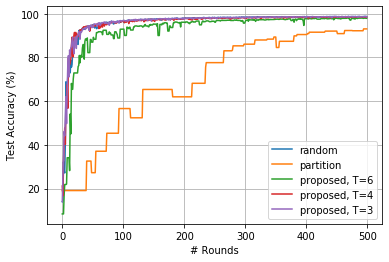

In [52]:
plt.plot(acc_test_arr[0,0,:], label='random')
plt.plot(acc_test_arr_partition[:], label='partition')
plt.plot(acc_test_arr_Proposed_N120_K12_T6[:], label='proposed, T=6')
plt.plot(acc_test_arr_Proposed_N120_K12_T4[:], label='proposed, T=4')
plt.plot(acc_test_arr_Proposed_N120_K12_T3[:], label='proposed, T=3')
# plt.plot(acc_test_arr_Proposed_N40_K8_T2[:], label='proposed, T=2')
# plt.plot(mean_fairness_N120_pdiff_noSelection[3,:], label='proposed, T=4')
# plt.plot(mean_fairness_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('# Rounds')
# plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

# 2. Asymmetric Dropout Probability

Dropout probability of each class is different, i.e., 
Pr{ dropout of class i } = Uniform{0.1, 0.2, 0.3, 0.4, 0.5}

In [4]:
# load dataset and split users

from torchvision import datasets, transforms

from utils.sampling import mnist_noniid2

if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid2(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        dict_users = cifar_noniid(dataset_train, args.num_users)
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

In [5]:
N = 120
K = 12

# p_per_class = np.array([-0.1, -0.05, 0 , 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])+0.025

p_per_class = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.3, 0.35, 0.4, 0.45, 0.5])
print(p_per_class)

p_per_user = np.zeros((N,))

for i in range(N):
    idxs=dict_users[i].astype(int)
    target = np.array(dataset_train.targets)
    cur_labels = target[idxs]
#     print(np.shape(target))
#     print(target[idxs])
    
    label_first = int(cur_labels[0])
    label_second = int(cur_labels[-1])
    
#     print(i,cur_labels)
#     print(i,label_first,label_second)
    
    p_per_user[i] = np.max([p_per_class[label_first] + p_per_class[label_second], 0])/2
#     print(p_per_class[label_first] + p_per_class[label_second], p_per_user[i])
print(p_per_user)

print(np.sum(p_per_user)/120)

[0.1  0.15 0.2  0.25 0.3  0.3  0.35 0.4  0.45 0.5 ]
[0.4   0.35  0.5   0.25  0.1   0.1   0.3   0.35  0.4   0.2   0.3   0.15
 0.5   0.3   0.3   0.4   0.3   0.325 0.275 0.45  0.35  0.5   0.15  0.15
 0.5   0.3   0.15  0.5   0.35  0.45  0.5   0.3   0.45  0.225 0.25  0.3
 0.45  0.3   0.5   0.5   0.25  0.45  0.2   0.25  0.45  0.3   0.5   0.15
 0.35  0.4   0.2   0.25  0.1   0.1   0.45  0.15  0.15  0.3   0.1   0.3
 0.35  0.2   0.2   0.1   0.15  0.25  0.25  0.35  0.45  0.4   0.3   0.2
 0.4   0.3   0.35  0.3   0.45  0.475 0.35  0.2   0.3   0.2   0.25  0.4
 0.4   0.4   0.45  0.25  0.3   0.15  0.15  0.25  0.45  0.15  0.425 0.4
 0.125 0.1   0.35  0.1   0.3   0.3   0.1   0.15  0.2   0.2   0.4   0.175
 0.375 0.15  0.3   0.1   0.25  0.5   0.2   0.1   0.3   0.4   0.5   0.3  ]
0.29791666666666666


In [6]:
from models.Nets import *

p = 0
N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]

acc_test_arr_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))



P_random_asymDrop = []

for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
#             u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random_asymDrop.append(p_tmp)


        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_asymDrop[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.5153 
Accuracy: 1032/10000 (10.32%)

Round   0, Train average loss 0.736 Test accuracy 10.320

Test set: Average loss: 2.3161 
Accuracy: 2261/10000 (22.61%)

Round   1, Train average loss 0.705 Test accuracy 22.610

Test set: Average loss: 2.5786 
Accuracy: 2988/10000 (29.88%)

Round   2, Train average loss 0.707 Test accuracy 29.880

Test set: Average loss: 2.1349 
Accuracy: 2539/10000 (25.39%)

Round   3, Train average loss 1.002 Test accuracy 25.390

Test set: Average loss: 2.2412 
Accuracy: 2648/10000 (26.48%)

Round   4, Train average loss 0.728 Test accuracy 26.480

Test set: Average loss: 2.1747 
Accuracy: 2502/10000 (25.02%)

Round   5, Train average loss 0.844 Test accuracy 25.020

Test s


Test set: Average loss: 0.2931 
Accuracy: 9123/10000 (91.23%)

Round  66, Train average loss 0.105 Test accuracy 91.230

Test set: Average loss: 0.3560 
Accuracy: 8832/10000 (88.32%)

Round  67, Train average loss 0.105 Test accuracy 88.320

Test set: Average loss: 0.2694 
Accuracy: 9213/10000 (92.13%)

Round  68, Train average loss 0.112 Test accuracy 92.130

Test set: Average loss: 0.2948 
Accuracy: 9095/10000 (90.95%)

Round  69, Train average loss 0.073 Test accuracy 90.950

Test set: Average loss: 0.2803 
Accuracy: 9164/10000 (91.64%)

Round  70, Train average loss 0.083 Test accuracy 91.640

Test set: Average loss: 0.2971 
Accuracy: 9087/10000 (90.87%)

Round  71, Train average loss 0.089 Test accuracy 90.870

Test set: Average loss: 0.2431 
Accuracy: 9326/10000 (93.26%)

Round  72, Train average loss 0.104 Test accuracy 93.260

Test set: Average loss: 0.2785 
Accuracy: 9166/10000 (91.66%)

Round  73, Train average loss 0.089 Test accuracy 91.660

Test set: Average loss: 0.2744 


Test set: Average loss: 0.2005 
Accuracy: 9381/10000 (93.81%)

Round 134, Train average loss 0.081 Test accuracy 93.810

Test set: Average loss: 0.2139 
Accuracy: 9315/10000 (93.15%)

Round 135, Train average loss 0.086 Test accuracy 93.150

Test set: Average loss: 0.1534 
Accuracy: 9560/10000 (95.60%)

Round 136, Train average loss 0.079 Test accuracy 95.600

Test set: Average loss: 0.1813 
Accuracy: 9450/10000 (94.50%)

Round 137, Train average loss 0.061 Test accuracy 94.500

Test set: Average loss: 0.2151 
Accuracy: 9249/10000 (92.49%)

Round 138, Train average loss 0.057 Test accuracy 92.490

Test set: Average loss: 0.2294 
Accuracy: 9166/10000 (91.66%)

Round 139, Train average loss 0.053 Test accuracy 91.660

Test set: Average loss: 0.1996 
Accuracy: 9334/10000 (93.34%)

Round 140, Train average loss 0.068 Test accuracy 93.340

Test set: Average loss: 0.1682 
Accuracy: 9496/10000 (94.96%)

Round 141, Train average loss 0.063 Test accuracy 94.960

Test set: Average loss: 0.1707 


Test set: Average loss: 4.3989 
Accuracy: 1135/10000 (11.35%)

Round   0, Train average loss 1.003 Test accuracy 11.350

Test set: Average loss: 2.7917 
Accuracy: 1782/10000 (17.82%)

Round   1, Train average loss 0.803 Test accuracy 17.820

Test set: Average loss: 2.8459 
Accuracy: 1009/10000 (10.09%)

Round   2, Train average loss 1.283 Test accuracy 10.090

Test set: Average loss: 2.5137 
Accuracy: 982/10000 (9.82%)

Round   3, Train average loss 1.203 Test accuracy 9.820

Test set: Average loss: 2.2485 
Accuracy: 1384/10000 (13.84%)

Round   4, Train average loss 1.508 Test accuracy 13.840

Test set: Average loss: 2.2285 
Accuracy: 1014/10000 (10.14%)

Round   5, Train average loss 1.117 Test accuracy 10.140

Test set: Average loss: 2.0777 
Accuracy: 3053/10000 (30.53%)

Round   6, Train average loss 1.199 Test accuracy 30.530

Test set: Average loss: 2.4066 
Accuracy: 1822/10000 (18.22%)

Round   7, Train average loss 0.805 Test accuracy 18.220

Test set: Average loss: 2.1000 
Ac


Test set: Average loss: 0.3326 
Accuracy: 8978/10000 (89.78%)

Round  68, Train average loss 0.105 Test accuracy 89.780

Test set: Average loss: 0.4444 
Accuracy: 8462/10000 (84.62%)

Round  69, Train average loss 0.121 Test accuracy 84.620

Test set: Average loss: 0.6024 
Accuracy: 7870/10000 (78.70%)

Round  70, Train average loss 0.117 Test accuracy 78.700

Test set: Average loss: 0.3441 
Accuracy: 9000/10000 (90.00%)

Round  71, Train average loss 0.193 Test accuracy 90.000

Test set: Average loss: 0.2952 
Accuracy: 9182/10000 (91.82%)

Round  72, Train average loss 0.122 Test accuracy 91.820

Test set: Average loss: 0.3052 
Accuracy: 9133/10000 (91.33%)

Round  73, Train average loss 0.088 Test accuracy 91.330

Test set: Average loss: 0.3152 
Accuracy: 8997/10000 (89.97%)

Round  74, Train average loss 0.102 Test accuracy 89.970

Test set: Average loss: 0.3147 
Accuracy: 9021/10000 (90.21%)

Round  75, Train average loss 0.125 Test accuracy 90.210

Test set: Average loss: 0.2966 


Test set: Average loss: 0.1707 
Accuracy: 9479/10000 (94.79%)

Round 136, Train average loss 0.086 Test accuracy 94.790

Test set: Average loss: 0.1966 
Accuracy: 9359/10000 (93.59%)

Round 137, Train average loss 0.060 Test accuracy 93.590

Test set: Average loss: 0.1971 
Accuracy: 9407/10000 (94.07%)

Round 138, Train average loss 0.092 Test accuracy 94.070

Test set: Average loss: 0.1579 
Accuracy: 9545/10000 (95.45%)

Round 139, Train average loss 0.089 Test accuracy 95.450

Test set: Average loss: 0.1772 
Accuracy: 9445/10000 (94.45%)

Round 140, Train average loss 0.081 Test accuracy 94.450

Test set: Average loss: 0.1786 
Accuracy: 9464/10000 (94.64%)

Round 141, Train average loss 0.069 Test accuracy 94.640

Test set: Average loss: 0.1855 
Accuracy: 9435/10000 (94.35%)

Round 142, Train average loss 0.081 Test accuracy 94.350

Test set: Average loss: 0.1835 
Accuracy: 9449/10000 (94.49%)

Round 143, Train average loss 0.064 Test accuracy 94.490

Test set: Average loss: 0.1628 


Test set: Average loss: 2.4490 
Accuracy: 981/10000 (9.81%)

Round   2, Train average loss 1.231 Test accuracy 9.810

Test set: Average loss: 2.2057 
Accuracy: 2380/10000 (23.80%)

Round   3, Train average loss 1.438 Test accuracy 23.800

Test set: Average loss: 2.0745 
Accuracy: 3387/10000 (33.87%)

Round   4, Train average loss 1.000 Test accuracy 33.870

Test set: Average loss: 1.9918 
Accuracy: 3981/10000 (39.81%)

Round   5, Train average loss 0.925 Test accuracy 39.810

Test set: Average loss: 2.0952 
Accuracy: 2937/10000 (29.37%)

Round   6, Train average loss 0.788 Test accuracy 29.370

Test set: Average loss: 1.9664 
Accuracy: 3872/10000 (38.72%)

Round   7, Train average loss 1.356 Test accuracy 38.720

Test set: Average loss: 1.8398 
Accuracy: 3485/10000 (34.85%)

Round   8, Train average loss 0.931 Test accuracy 34.850

Test set: Average loss: 1.7248 
Accuracy: 4465/10000 (44.65%)

Round   9, Train average loss 0.757 Test accuracy 44.650

Test set: Average loss: 1.6590 
Ac


Test set: Average loss: 0.4939 
Accuracy: 8437/10000 (84.37%)

Round  70, Train average loss 0.082 Test accuracy 84.370

Test set: Average loss: 0.4826 
Accuracy: 8449/10000 (84.49%)

Round  71, Train average loss 0.271 Test accuracy 84.490

Test set: Average loss: 0.5504 
Accuracy: 8083/10000 (80.83%)

Round  72, Train average loss 0.282 Test accuracy 80.830

Test set: Average loss: 0.7505 
Accuracy: 7451/10000 (74.51%)

Round  73, Train average loss 0.318 Test accuracy 74.510

Test set: Average loss: 0.5724 
Accuracy: 8124/10000 (81.24%)

Round  74, Train average loss 0.488 Test accuracy 81.240

Test set: Average loss: 0.5406 
Accuracy: 8173/10000 (81.73%)

Round  75, Train average loss 0.328 Test accuracy 81.730

Test set: Average loss: 0.4811 
Accuracy: 8452/10000 (84.52%)

Round  76, Train average loss 0.092 Test accuracy 84.520

Test set: Average loss: 0.4699 
Accuracy: 8507/10000 (85.07%)

Round  77, Train average loss 0.281 Test accuracy 85.070

Test set: Average loss: 0.4673 


Test set: Average loss: 0.4242 
Accuracy: 8533/10000 (85.33%)

Round 138, Train average loss 0.087 Test accuracy 85.330

Test set: Average loss: 0.3958 
Accuracy: 8621/10000 (86.21%)

Round 139, Train average loss 0.058 Test accuracy 86.210

Test set: Average loss: 0.3981 
Accuracy: 8639/10000 (86.39%)

Round 140, Train average loss 0.065 Test accuracy 86.390

Test set: Average loss: 0.3904 
Accuracy: 8663/10000 (86.63%)

Round 141, Train average loss 0.458 Test accuracy 86.630

Test set: Average loss: 0.3831 
Accuracy: 8690/10000 (86.90%)

Round 142, Train average loss 0.644 Test accuracy 86.900

Test set: Average loss: 0.3902 
Accuracy: 8636/10000 (86.36%)

Round 143, Train average loss 0.061 Test accuracy 86.360

Test set: Average loss: 0.4088 
Accuracy: 8543/10000 (85.43%)

Round 144, Train average loss 0.246 Test accuracy 85.430

Test set: Average loss: 0.4747 
Accuracy: 8243/10000 (82.43%)

Round 145, Train average loss 0.054 Test accuracy 82.430

Test set: Average loss: 0.4667 


Test set: Average loss: 2.2311 
Accuracy: 2792/10000 (27.92%)

Round   4, Train average loss 0.509 Test accuracy 27.920

Test set: Average loss: 3.0753 
Accuracy: 892/10000 (8.92%)

Round   5, Train average loss 0.739 Test accuracy 8.920

Test set: Average loss: 2.0206 
Accuracy: 3200/10000 (32.00%)

Round   6, Train average loss 0.938 Test accuracy 32.000

Test set: Average loss: 2.0041 
Accuracy: 3955/10000 (39.55%)

Round   7, Train average loss 0.456 Test accuracy 39.550

Test set: Average loss: 1.9877 
Accuracy: 2908/10000 (29.08%)

Round   8, Train average loss 0.433 Test accuracy 29.080

Test set: Average loss: 1.8157 
Accuracy: 4142/10000 (41.42%)

Round   9, Train average loss 0.796 Test accuracy 41.420

Test set: Average loss: 1.5767 
Accuracy: 5956/10000 (59.56%)

Round  10, Train average loss 1.145 Test accuracy 59.560

Test set: Average loss: 1.4369 
Accuracy: 5928/10000 (59.28%)

Round  11, Train average loss 0.482 Test accuracy 59.280

Test set: Average loss: 1.7613 
Ac


Test set: Average loss: 0.2784 
Accuracy: 9124/10000 (91.24%)

Round  72, Train average loss 0.107 Test accuracy 91.240

Test set: Average loss: 0.2466 
Accuracy: 9271/10000 (92.71%)

Round  73, Train average loss 0.087 Test accuracy 92.710

Test set: Average loss: 0.2476 
Accuracy: 9303/10000 (93.03%)

Round  74, Train average loss 0.098 Test accuracy 93.030

Test set: Average loss: 0.2328 
Accuracy: 9337/10000 (93.37%)

Round  75, Train average loss 0.096 Test accuracy 93.370

Test set: Average loss: 0.2655 
Accuracy: 9185/10000 (91.85%)

Round  76, Train average loss 0.072 Test accuracy 91.850

Test set: Average loss: 0.3226 
Accuracy: 8986/10000 (89.86%)

Round  77, Train average loss 0.133 Test accuracy 89.860

Test set: Average loss: 0.4299 
Accuracy: 8520/10000 (85.20%)

Round  78, Train average loss 0.129 Test accuracy 85.200

Test set: Average loss: 0.3024 
Accuracy: 9058/10000 (90.58%)

Round  79, Train average loss 0.105 Test accuracy 90.580

Test set: Average loss: 0.2432 


Test set: Average loss: 0.1492 
Accuracy: 9554/10000 (95.54%)

Round 140, Train average loss 0.065 Test accuracy 95.540

Test set: Average loss: 0.1741 
Accuracy: 9477/10000 (94.77%)

Round 141, Train average loss 0.061 Test accuracy 94.770

Test set: Average loss: 0.2265 
Accuracy: 9246/10000 (92.46%)

Round 142, Train average loss 0.085 Test accuracy 92.460

Test set: Average loss: 0.1686 
Accuracy: 9488/10000 (94.88%)

Round 143, Train average loss 0.069 Test accuracy 94.880

Test set: Average loss: 0.1713 
Accuracy: 9474/10000 (94.74%)

Round 144, Train average loss 0.053 Test accuracy 94.740

Test set: Average loss: 0.1984 
Accuracy: 9347/10000 (93.47%)

Round 145, Train average loss 0.066 Test accuracy 93.470

Test set: Average loss: 0.1676 
Accuracy: 9489/10000 (94.89%)

Round 146, Train average loss 0.066 Test accuracy 94.890

Test set: Average loss: 0.1523 
Accuracy: 9555/10000 (95.55%)

Round 147, Train average loss 0.058 Test accuracy 95.550

Test set: Average loss: 0.1727 


Test set: Average loss: 2.0873 
Accuracy: 1772/10000 (17.72%)

Round   6, Train average loss 0.873 Test accuracy 17.720

Test set: Average loss: 2.2511 
Accuracy: 2167/10000 (21.67%)

Round   7, Train average loss 0.418 Test accuracy 21.670

Test set: Average loss: 2.3313 
Accuracy: 1269/10000 (12.69%)

Round   8, Train average loss 0.997 Test accuracy 12.690

Test set: Average loss: 1.9142 
Accuracy: 3789/10000 (37.89%)

Round   9, Train average loss 0.696 Test accuracy 37.890

Test set: Average loss: 1.7796 
Accuracy: 4138/10000 (41.38%)

Round  10, Train average loss 0.702 Test accuracy 41.380

Test set: Average loss: 1.8662 
Accuracy: 3880/10000 (38.80%)

Round  11, Train average loss 1.235 Test accuracy 38.800

Test set: Average loss: 1.6076 
Accuracy: 4912/10000 (49.12%)

Round  12, Train average loss 0.926 Test accuracy 49.120

Test set: Average loss: 1.5092 
Accuracy: 5104/10000 (51.04%)

Round  13, Train average loss 0.330 Test accuracy 51.040

Test set: Average loss: 2.6755 


Test set: Average loss: 0.5179 
Accuracy: 9100/10000 (91.00%)

Round  74, Train average loss 0.516 Test accuracy 91.000

Test set: Average loss: 0.5169 
Accuracy: 9075/10000 (90.75%)

Round  75, Train average loss 0.093 Test accuracy 90.750

Test set: Average loss: 0.6863 
Accuracy: 8167/10000 (81.67%)

Round  76, Train average loss 0.283 Test accuracy 81.670

Test set: Average loss: 0.5283 
Accuracy: 9077/10000 (90.77%)

Round  77, Train average loss 0.471 Test accuracy 90.770

Test set: Average loss: 0.5437 
Accuracy: 8777/10000 (87.77%)

Round  78, Train average loss 0.125 Test accuracy 87.770

Test set: Average loss: 0.5764 
Accuracy: 8603/10000 (86.03%)

Round  79, Train average loss 0.276 Test accuracy 86.030

Test set: Average loss: 0.4912 
Accuracy: 9161/10000 (91.61%)

Round  80, Train average loss 0.473 Test accuracy 91.610

Test set: Average loss: 0.5037 
Accuracy: 9031/10000 (90.31%)

Round  81, Train average loss 0.103 Test accuracy 90.310

Test set: Average loss: 0.4834 


Test set: Average loss: 0.4250 
Accuracy: 9340/10000 (93.40%)

Round 142, Train average loss 0.413 Test accuracy 93.400

Test set: Average loss: 0.4210 
Accuracy: 9374/10000 (93.74%)

Round 143, Train average loss 0.442 Test accuracy 93.740

Test set: Average loss: 0.4064 
Accuracy: 9386/10000 (93.86%)

Round 144, Train average loss 0.072 Test accuracy 93.860

Test set: Average loss: 0.4243 
Accuracy: 9339/10000 (93.39%)

Round 145, Train average loss 0.456 Test accuracy 93.390

Test set: Average loss: 0.4421 
Accuracy: 9231/10000 (92.31%)

Round 146, Train average loss 0.254 Test accuracy 92.310

Test set: Average loss: 0.4711 
Accuracy: 8998/10000 (89.98%)

Round 147, Train average loss 0.258 Test accuracy 89.980

Test set: Average loss: 0.4079 
Accuracy: 9411/10000 (94.11%)

Round 148, Train average loss 0.266 Test accuracy 94.110

Test set: Average loss: 0.4063 
Accuracy: 9428/10000 (94.28%)

Round 149, Train average loss 0.446 Test accuracy 94.280

Test set: Average loss: 0.4021 

## 2.2. Weighted Random Selection

In [7]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_w_random_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_w_random_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))





for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_w_random_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
#             u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
            result = np.where(u == 1)
            drop_result = np.where(u == 0)

            ###############################
            # 1. Weighted Random Selection
            ###############################

            if iter == 0:
                idxs_users = np.random.choice(result[0], K, replace=False)
#                 print('select=',select)
            else:
                P = np.array(P_w_random_asymDrop)
                P_sum = np.sum(P, axis=0).astype(int)
        
                for i in drop_result[0]:
                    P_sum[i] = Max_iter + 1   

                P_sum_sort = P_sum.argsort()

                idxs_users = P_sum_sort[:K]
            

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_w_random_asymDrop.append(p_tmp)


        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_w_random_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_w_random_asymDrop[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.5558 
Accuracy: 980/10000 (9.80%)

Round   0, Train average loss 0.925 Test accuracy 9.800

Test set: Average loss: 2.3688 
Accuracy: 1013/10000 (10.13%)

Round   1, Train average loss 0.935 Test accuracy 10.130

Test set: Average loss: 2.7097 
Accuracy: 2028/10000 (20.28%)

Round   2, Train average loss 0.567 Test accuracy 20.280

Test set: Average loss: 2.4726 
Accuracy: 1925/10000 (19.25%)

Round   3, Train average loss 0.962 Test accuracy 19.250

Test set: Average loss: 2.2879 
Accuracy: 976/10000 (9.76%)

Round   4, Train average loss 1.150 Test accuracy 9.760

Test set: Average loss: 2.3533 
Accuracy: 2171/10000 (21.71%)

Round   5, Train average loss 0.838 Test accuracy 21.710

Test set: Av


Test set: Average loss: 0.5174 
Accuracy: 8417/10000 (84.17%)

Round  66, Train average loss 0.703 Test accuracy 84.170

Test set: Average loss: 0.5158 
Accuracy: 8471/10000 (84.71%)

Round  67, Train average loss 0.698 Test accuracy 84.710

Test set: Average loss: 0.5637 
Accuracy: 8259/10000 (82.59%)

Round  68, Train average loss 0.097 Test accuracy 82.590

Test set: Average loss: 0.5413 
Accuracy: 8305/10000 (83.05%)

Round  69, Train average loss 0.095 Test accuracy 83.050

Test set: Average loss: 0.4961 
Accuracy: 8450/10000 (84.50%)

Round  70, Train average loss 0.491 Test accuracy 84.500

Test set: Average loss: 0.5137 
Accuracy: 8373/10000 (83.73%)

Round  71, Train average loss 0.488 Test accuracy 83.730

Test set: Average loss: 0.4806 
Accuracy: 8467/10000 (84.67%)

Round  72, Train average loss 0.288 Test accuracy 84.670

Test set: Average loss: 0.5042 
Accuracy: 8391/10000 (83.91%)

Round  73, Train average loss 0.474 Test accuracy 83.910

Test set: Average loss: 0.5336 


Test set: Average loss: 0.3723 
Accuracy: 8710/10000 (87.10%)

Round 134, Train average loss 0.127 Test accuracy 87.100

Test set: Average loss: 0.6365 
Accuracy: 8449/10000 (84.49%)

Round 135, Train average loss 0.138 Test accuracy 84.490

Test set: Average loss: 0.3250 
Accuracy: 9349/10000 (93.49%)

Round 136, Train average loss 0.326 Test accuracy 93.490

Test set: Average loss: 0.2420 
Accuracy: 9439/10000 (94.39%)

Round 137, Train average loss 0.119 Test accuracy 94.390

Test set: Average loss: 0.2108 
Accuracy: 9422/10000 (94.22%)

Round 138, Train average loss 0.085 Test accuracy 94.220

Test set: Average loss: 0.2377 
Accuracy: 9236/10000 (92.36%)

Round 139, Train average loss 0.077 Test accuracy 92.360

Test set: Average loss: 0.1811 
Accuracy: 9504/10000 (95.04%)

Round 140, Train average loss 0.088 Test accuracy 95.040

Test set: Average loss: 0.2025 
Accuracy: 9497/10000 (94.97%)

Round 141, Train average loss 0.071 Test accuracy 94.970

Test set: Average loss: 0.1894 


Test set: Average loss: 2.3387 
Accuracy: 1365/10000 (13.65%)

Round   0, Train average loss 0.836 Test accuracy 13.650

Test set: Average loss: 3.3227 
Accuracy: 980/10000 (9.80%)

Round   1, Train average loss 0.685 Test accuracy 9.800

Test set: Average loss: 2.2456 
Accuracy: 1964/10000 (19.64%)

Round   2, Train average loss 1.133 Test accuracy 19.640

Test set: Average loss: 2.1660 
Accuracy: 1998/10000 (19.98%)

Round   3, Train average loss 1.095 Test accuracy 19.980

Test set: Average loss: 2.4912 
Accuracy: 2157/10000 (21.57%)

Round   4, Train average loss 0.730 Test accuracy 21.570

Test set: Average loss: 2.2920 
Accuracy: 1328/10000 (13.28%)

Round   5, Train average loss 0.809 Test accuracy 13.280

Test set: Average loss: 1.9223 
Accuracy: 4258/10000 (42.58%)

Round   6, Train average loss 0.879 Test accuracy 42.580

Test set: Average loss: 2.2723 
Accuracy: 2120/10000 (21.20%)

Round   7, Train average loss 0.564 Test accuracy 21.200

Test set: Average loss: 2.1130 
Ac


Test set: Average loss: 0.2286 
Accuracy: 9356/10000 (93.56%)

Round  68, Train average loss 0.081 Test accuracy 93.560

Test set: Average loss: 0.2818 
Accuracy: 9123/10000 (91.23%)

Round  69, Train average loss 0.087 Test accuracy 91.230

Test set: Average loss: 0.2519 
Accuracy: 9232/10000 (92.32%)

Round  70, Train average loss 0.093 Test accuracy 92.320

Test set: Average loss: 0.2618 
Accuracy: 9218/10000 (92.18%)

Round  71, Train average loss 0.071 Test accuracy 92.180

Test set: Average loss: 0.2866 
Accuracy: 9105/10000 (91.05%)

Round  72, Train average loss 0.120 Test accuracy 91.050

Test set: Average loss: 0.2982 
Accuracy: 9114/10000 (91.14%)

Round  73, Train average loss 0.097 Test accuracy 91.140

Test set: Average loss: 0.3204 
Accuracy: 8923/10000 (89.23%)

Round  74, Train average loss 0.117 Test accuracy 89.230

Test set: Average loss: 0.2412 
Accuracy: 9289/10000 (92.89%)

Round  75, Train average loss 0.108 Test accuracy 92.890

Test set: Average loss: 0.2815 


Test set: Average loss: 0.1658 
Accuracy: 9457/10000 (94.57%)

Round 136, Train average loss 0.069 Test accuracy 94.570

Test set: Average loss: 0.1479 
Accuracy: 9563/10000 (95.63%)

Round 137, Train average loss 0.072 Test accuracy 95.630

Test set: Average loss: 0.1411 
Accuracy: 9576/10000 (95.76%)

Round 138, Train average loss 0.068 Test accuracy 95.760

Test set: Average loss: 0.1850 
Accuracy: 9391/10000 (93.91%)

Round 139, Train average loss 0.058 Test accuracy 93.910

Test set: Average loss: 0.1801 
Accuracy: 9415/10000 (94.15%)

Round 140, Train average loss 0.059 Test accuracy 94.150

Test set: Average loss: 0.1368 
Accuracy: 9601/10000 (96.01%)

Round 141, Train average loss 0.075 Test accuracy 96.010

Test set: Average loss: 0.1496 
Accuracy: 9570/10000 (95.70%)

Round 142, Train average loss 0.052 Test accuracy 95.700

Test set: Average loss: 0.1312 
Accuracy: 9616/10000 (96.16%)

Round 143, Train average loss 0.088 Test accuracy 96.160

Test set: Average loss: 0.1591 


Test set: Average loss: 2.3337 
Accuracy: 1144/10000 (11.44%)

Round   2, Train average loss 1.425 Test accuracy 11.440

Test set: Average loss: 2.3815 
Accuracy: 1911/10000 (19.11%)

Round   3, Train average loss 1.357 Test accuracy 19.110

Test set: Average loss: 2.6140 
Accuracy: 982/10000 (9.82%)

Round   4, Train average loss 1.004 Test accuracy 9.820

Test set: Average loss: 2.2701 
Accuracy: 2647/10000 (26.47%)

Round   5, Train average loss 1.021 Test accuracy 26.470

Test set: Average loss: 2.0918 
Accuracy: 2519/10000 (25.19%)

Round   6, Train average loss 1.256 Test accuracy 25.190

Test set: Average loss: 2.0146 
Accuracy: 3654/10000 (36.54%)

Round   7, Train average loss 0.904 Test accuracy 36.540

Test set: Average loss: 1.9587 
Accuracy: 5433/10000 (54.33%)

Round   8, Train average loss 1.447 Test accuracy 54.330

Test set: Average loss: 2.1943 
Accuracy: 1839/10000 (18.39%)

Round   9, Train average loss 0.898 Test accuracy 18.390

Test set: Average loss: 2.1687 
Ac


Test set: Average loss: 0.5445 
Accuracy: 8251/10000 (82.51%)

Round  70, Train average loss 0.495 Test accuracy 82.510

Test set: Average loss: 0.5317 
Accuracy: 8287/10000 (82.87%)

Round  71, Train average loss 0.278 Test accuracy 82.870

Test set: Average loss: 0.6256 
Accuracy: 7912/10000 (79.12%)

Round  72, Train average loss 0.496 Test accuracy 79.120

Test set: Average loss: 0.7611 
Accuracy: 7437/10000 (74.37%)

Round  73, Train average loss 0.505 Test accuracy 74.370

Test set: Average loss: 0.5849 
Accuracy: 8087/10000 (80.87%)

Round  74, Train average loss 0.361 Test accuracy 80.870

Test set: Average loss: 0.5864 
Accuracy: 8039/10000 (80.39%)

Round  75, Train average loss 0.287 Test accuracy 80.390

Test set: Average loss: 0.6970 
Accuracy: 7585/10000 (75.85%)

Round  76, Train average loss 0.635 Test accuracy 75.850

Test set: Average loss: 0.5911 
Accuracy: 7974/10000 (79.74%)

Round  77, Train average loss 0.133 Test accuracy 79.740

Test set: Average loss: 0.6773 


Test set: Average loss: 0.1805 
Accuracy: 9436/10000 (94.36%)

Round 138, Train average loss 0.064 Test accuracy 94.360

Test set: Average loss: 0.1811 
Accuracy: 9460/10000 (94.60%)

Round 139, Train average loss 0.063 Test accuracy 94.600

Test set: Average loss: 0.1586 
Accuracy: 9548/10000 (95.48%)

Round 140, Train average loss 0.073 Test accuracy 95.480

Test set: Average loss: 0.1784 
Accuracy: 9463/10000 (94.63%)

Round 141, Train average loss 0.068 Test accuracy 94.630

Test set: Average loss: 0.1767 
Accuracy: 9482/10000 (94.82%)

Round 142, Train average loss 0.057 Test accuracy 94.820

Test set: Average loss: 0.1718 
Accuracy: 9506/10000 (95.06%)

Round 143, Train average loss 0.086 Test accuracy 95.060

Test set: Average loss: 0.1947 
Accuracy: 9370/10000 (93.70%)

Round 144, Train average loss 0.067 Test accuracy 93.700

Test set: Average loss: 0.2253 
Accuracy: 9260/10000 (92.60%)

Round 145, Train average loss 0.048 Test accuracy 92.600

Test set: Average loss: 0.2324 


Test set: Average loss: 2.3978 
Accuracy: 1011/10000 (10.11%)

Round   4, Train average loss 1.196 Test accuracy 10.110

Test set: Average loss: 2.0995 
Accuracy: 2536/10000 (25.36%)

Round   5, Train average loss 0.930 Test accuracy 25.360

Test set: Average loss: 2.3339 
Accuracy: 1177/10000 (11.77%)

Round   6, Train average loss 0.917 Test accuracy 11.770

Test set: Average loss: 2.3833 
Accuracy: 1792/10000 (17.92%)

Round   7, Train average loss 0.866 Test accuracy 17.920

Test set: Average loss: 2.0093 
Accuracy: 3176/10000 (31.76%)

Round   8, Train average loss 1.194 Test accuracy 31.760

Test set: Average loss: 2.1791 
Accuracy: 2267/10000 (22.67%)

Round   9, Train average loss 0.874 Test accuracy 22.670

Test set: Average loss: 2.6061 
Accuracy: 901/10000 (9.01%)

Round  10, Train average loss 0.617 Test accuracy 9.010

Test set: Average loss: 1.7568 
Accuracy: 5312/10000 (53.12%)

Round  11, Train average loss 0.927 Test accuracy 53.120

Test set: Average loss: 1.7580 
Ac


Test set: Average loss: 0.4706 
Accuracy: 8507/10000 (85.07%)

Round  72, Train average loss 0.301 Test accuracy 85.070

Test set: Average loss: 0.6711 
Accuracy: 8048/10000 (80.48%)

Round  73, Train average loss 0.108 Test accuracy 80.480

Test set: Average loss: 0.5361 
Accuracy: 8261/10000 (82.61%)

Round  74, Train average loss 0.313 Test accuracy 82.610

Test set: Average loss: 0.4849 
Accuracy: 8453/10000 (84.53%)

Round  75, Train average loss 0.487 Test accuracy 84.530

Test set: Average loss: 0.5393 
Accuracy: 8246/10000 (82.46%)

Round  76, Train average loss 0.260 Test accuracy 82.460

Test set: Average loss: 0.5292 
Accuracy: 8281/10000 (82.81%)

Round  77, Train average loss 0.121 Test accuracy 82.810

Test set: Average loss: 0.5302 
Accuracy: 8306/10000 (83.06%)

Round  78, Train average loss 0.320 Test accuracy 83.060

Test set: Average loss: 0.5301 
Accuracy: 8277/10000 (82.77%)

Round  79, Train average loss 0.113 Test accuracy 82.770

Test set: Average loss: 0.4964 


Test set: Average loss: 0.4314 
Accuracy: 8523/10000 (85.23%)

Round 140, Train average loss 0.440 Test accuracy 85.230

Test set: Average loss: 0.4118 
Accuracy: 8586/10000 (85.86%)

Round 141, Train average loss 0.261 Test accuracy 85.860

Test set: Average loss: 0.3826 
Accuracy: 8660/10000 (86.60%)

Round 142, Train average loss 0.277 Test accuracy 86.600

Test set: Average loss: 0.3931 
Accuracy: 8638/10000 (86.38%)

Round 143, Train average loss 0.079 Test accuracy 86.380

Test set: Average loss: 0.4215 
Accuracy: 8531/10000 (85.31%)

Round 144, Train average loss 0.456 Test accuracy 85.310

Test set: Average loss: 0.3972 
Accuracy: 8631/10000 (86.31%)

Round 145, Train average loss 0.456 Test accuracy 86.310

Test set: Average loss: 0.4343 
Accuracy: 8532/10000 (85.32%)

Round 146, Train average loss 0.469 Test accuracy 85.320

Test set: Average loss: 0.4138 
Accuracy: 8568/10000 (85.68%)

Round 147, Train average loss 0.109 Test accuracy 85.680

Test set: Average loss: 0.3852 


Test set: Average loss: 2.2445 
Accuracy: 1264/10000 (12.64%)

Round   6, Train average loss 1.015 Test accuracy 12.640

Test set: Average loss: 2.0787 
Accuracy: 1761/10000 (17.61%)

Round   7, Train average loss 0.988 Test accuracy 17.610

Test set: Average loss: 1.8612 
Accuracy: 3513/10000 (35.13%)

Round   8, Train average loss 0.599 Test accuracy 35.130

Test set: Average loss: 1.8693 
Accuracy: 4371/10000 (43.71%)

Round   9, Train average loss 1.103 Test accuracy 43.710

Test set: Average loss: 1.9453 
Accuracy: 3372/10000 (33.72%)

Round  10, Train average loss 0.921 Test accuracy 33.720

Test set: Average loss: 1.8718 
Accuracy: 3454/10000 (34.54%)

Round  11, Train average loss 1.240 Test accuracy 34.540

Test set: Average loss: 1.5958 
Accuracy: 5374/10000 (53.74%)

Round  12, Train average loss 0.373 Test accuracy 53.740

Test set: Average loss: 1.5730 
Accuracy: 5662/10000 (56.62%)

Round  13, Train average loss 0.537 Test accuracy 56.620

Test set: Average loss: 1.5870 


Test set: Average loss: 0.3471 
Accuracy: 8860/10000 (88.60%)

Round  74, Train average loss 0.097 Test accuracy 88.600

Test set: Average loss: 0.4734 
Accuracy: 8244/10000 (82.44%)

Round  75, Train average loss 0.163 Test accuracy 82.440

Test set: Average loss: 0.2682 
Accuracy: 9202/10000 (92.02%)

Round  76, Train average loss 0.110 Test accuracy 92.020

Test set: Average loss: 0.2262 
Accuracy: 9355/10000 (93.55%)

Round  77, Train average loss 0.122 Test accuracy 93.550

Test set: Average loss: 0.2465 
Accuracy: 9296/10000 (92.96%)

Round  78, Train average loss 0.085 Test accuracy 92.960

Test set: Average loss: 0.2502 
Accuracy: 9242/10000 (92.42%)

Round  79, Train average loss 0.093 Test accuracy 92.420

Test set: Average loss: 0.2394 
Accuracy: 9319/10000 (93.19%)

Round  80, Train average loss 0.095 Test accuracy 93.190

Test set: Average loss: 0.2306 
Accuracy: 9317/10000 (93.17%)

Round  81, Train average loss 0.087 Test accuracy 93.170

Test set: Average loss: 0.3028 


Test set: Average loss: 0.1750 
Accuracy: 9472/10000 (94.72%)

Round 142, Train average loss 0.059 Test accuracy 94.720

Test set: Average loss: 0.1464 
Accuracy: 9570/10000 (95.70%)

Round 143, Train average loss 0.075 Test accuracy 95.700

Test set: Average loss: 0.1985 
Accuracy: 9358/10000 (93.58%)

Round 144, Train average loss 0.071 Test accuracy 93.580

Test set: Average loss: 0.1984 
Accuracy: 9352/10000 (93.52%)

Round 145, Train average loss 0.070 Test accuracy 93.520

Test set: Average loss: 0.2420 
Accuracy: 9108/10000 (91.08%)

Round 146, Train average loss 0.056 Test accuracy 91.080

Test set: Average loss: 0.1471 
Accuracy: 9547/10000 (95.47%)

Round 147, Train average loss 0.081 Test accuracy 95.470

Test set: Average loss: 0.1506 
Accuracy: 9559/10000 (95.59%)

Round 148, Train average loss 0.056 Test accuracy 95.590

Test set: Average loss: 0.1428 
Accuracy: 9583/10000 (95.83%)

Round 149, Train average loss 0.080 Test accuracy 95.830

Test set: Average loss: 0.1456 

In [43]:
P_tmp = np.array(P_random_asymDrop)
P_tmp_sum = np.sum(P_tmp, axis=0)
print(P_tmp_sum)
print(np.max(P_tmp_sum))
print(np.min(P_tmp_sum))

P_tmp = np.array(P_w_random_asymDrop)
P_tmp_sum = np.sum(P_tmp, axis=0)
print(P_tmp_sum)

[ 8. 16.  8.  8. 12. 17.  5. 15. 12. 11. 13.  9. 12.  6. 11. 12.  4.  7.
 10.  7. 11.  8.  8. 13. 11.  9. 11. 11.  5. 14.  9.  8. 17. 12. 11. 13.
  9.  4.  7.  8.  5.  9.  8. 14. 11. 12.  7.  5.  9. 10.  7. 13. 14.  9.
 11.  8. 10. 10.  9.  9. 11.  4. 12.  6.  8.  8. 10.  5.  7. 15. 10. 13.
 12. 11. 14. 10. 14.  4. 12.  6.  7.  6. 16. 15.  7. 10.  9.  7. 21.  8.
 10. 15.  7. 19.  7. 12. 20. 14. 10. 10. 12. 10.  3. 10.  7.  8.  7. 12.
 14.  7. 15.  9. 13. 10. 10.  8.  8. 10.  7.  6.]
21.0
3.0
[10. 10. 10.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10.  9. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 11. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 11. 10. 11. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10.  9. 10. 10. 10.]


In [8]:
N   = 120
K   = 12

Codebook_Proposed_T6 = CodeBookDesign_Bin(N,K,6)
Codebook_Proposed_T4 = CodeBookDesign_Bin(N,K,4)
Codebook_Proposed_T3 = CodeBookDesign_Bin(N,K,3)

Codebook_Partition = CodeBookDesign_Partition(N,K)

# print(Codebook_Partition)

@CodeBookDesign_Bin, Codebook Size= 190
@CodeBookDesign_Bin, Codebook Size= 4060
@CodeBookDesign_Bin, Codebook Size= 91389
@CodeBookDesign_Partition, Codebook Size= 10


In [14]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Proposed_N120_K12_T6_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T6_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T6_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T6 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=6, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=6, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T6[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T6_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T6[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T6_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T6_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T6_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 2.4896 
Accuracy: 1032/10000 (10.32%)

Round   0, Train average loss 0.731 Test accuracy 10.320
[iter= 1 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 2.4896 
Accuracy: 1032/10000 (10.32%)

Round   1, Train average loss 0.731 Test accuracy 10.320
[iter= 2 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 102
selected idx= 103
se


Test set: Average loss: 1.1492 
Accuracy: 6545/10000 (65.45%)

Round  26, Train average loss 0.244 Test accuracy 65.450
[iter= 27 ] @Proposed T=6, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3017 
Accuracy: 5946/10000 (59.46%)

Round  27, Train average loss 0.216 Test accuracy 59.460
[iter= 28 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.9179 
Accuracy: 7535/10000 (75.35%)

Round  28, Train average loss 0.369 Test accuracy 75.350
[iter= 29 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
se

selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.5489 
Accuracy: 8351/10000 (83.51%)

Round  53, Train average loss 0.130 Test accuracy 83.510
[iter= 54 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.5623 
Accuracy: 8052/10000 (80.52%)

Round  54, Train average loss 0.193 Test accuracy 80.520
[iter= 55 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 0.6889 
Accuracy: 7499/10000 (74.99%)

Round  55, Train average loss 0.162 Test accuracy 74.990
[iter= 56 ] @Proposed T=6, Codebook

selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.3693 
Accuracy: 8787/10000 (87.87%)

Round  78, Train average loss 0.143 Test accuracy 87.870
[iter= 79 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.3680 
Accuracy: 8772/10000 (87.72%)

Round  79, Train average loss 0.130 Test accuracy 87.720
[iter= 80 ] @Proposed T=6, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.3371 
Accuracy: 9038/10000 (90.38%)

Round  80, Train average loss 0.124 Test 

selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.2395 
Accuracy: 9305/10000 (93.05%)

Round 105, Train average loss 0.101 Test accuracy 93.050
[iter= 106 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.2411 
Accuracy: 9326/10000 (93.26%)

Round 106, Train average loss 0.105 Test accuracy 93.260
[iter= 107 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.2479 
Accuracy: 9252/10000 (92.52%)

Round 107, Train avera

selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.2257 
Accuracy: 9327/10000 (93.27%)

Round 129, Train average loss 0.080 Test accuracy 93.270
[iter= 130 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2257 
Accuracy: 9327/10000 (93.27%)

Round 130, Train average loss 0.080 Test accuracy 93.270
[iter= 131 ] @Proposed T=6, Codebook selection
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.2175 
Accuracy: 9351/10000 (93.51%)

Round 131, Train average loss 0.085 Test accuracy 93.510
[iter= 132 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
se

selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.2545 
Accuracy: 9154/10000 (91.54%)

Round 155, Train average loss 0.070 Test accuracy 91.540
[iter= 156 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.1886 
Accuracy: 9460/10000 (94.60%)

Round 156, Train average loss 0.090 Test accuracy 94.600
[iter= 157 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29

Test set: Average loss: 0.2102 
Accuracy: 9346/10000 (93.46%)

Round 157, Train average loss 0.084 Test accuracy 93.460
[iter= 158 ] @Proposed T=6, Codebook se


Test set: Average loss: 0.2652 
Accuracy: 9079/10000 (90.79%)

Round 183, Train average loss 0.079 Test accuracy 90.790
[iter= 184 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2652 
Accuracy: 9079/10000 (90.79%)

Round 184, Train average loss 0.079 Test accuracy 90.790
[iter= 185 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.1945 
Accuracy: 9390/10000 (93.90%)

Round 185, Train average loss 0.069 Test accuracy 93.900
[iter= 186 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1945 
Accuracy: 9390/10000 (93.90%)

Round 186, Train average loss 0.069 Test accuracy 93.900
[iter= 187 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1945 
Accuracy: 9390/10000 (93.90%)

Round 187, Train average

selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.9640 
Accuracy: 3285/10000 (32.85%)

Round  10, Train average loss 0.511 Test accuracy 32.850
[iter= 11 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.9023 
Accuracy: 3934/10000 (39.34%)

Round  11, Train average loss 1.015 Test accuracy 39.340
[iter= 12 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.6407 
Accuracy: 4875/10000 (48.75%)

Round  12, Train average loss 0.484 Test accu

selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.9010 
Accuracy: 7522/10000 (75.22%)

Round  35, Train average loss 0.631 Test accuracy 75.220
[iter= 36 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.9960 
Accuracy: 6724/10000 (67.24%)

Round  36, Train average loss 0.342 Test accuracy 67.240
[iter= 37 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.9960 
Accuracy: 6724/10000 (67.24%)

Round  37, Train average loss 0.342 Test accuracy 67.240
[iter= 38 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 66
selected idx=

selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.5741 
Accuracy: 8210/10000 (82.10%)

Round  61, Train average loss 0.106 Test accuracy 82.100
[iter= 62 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.5793 
Accuracy: 8177/10000 (81.77%)

Round  62, Train average loss 0.292 Test accuracy 81.770
[iter= 63 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.5793 
Accuracy: 8177/10000 (81.77%)

Round  63, Train average loss 0.292 Test accuracy 81.770
[iter= 64 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
sel

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.5555 
Accuracy: 8022/10000 (80.22%)

Round  85, Train average loss 0.096 Test accuracy 80.220
[iter= 86 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.5555 
Accuracy: 8022/10000 (80.22%)

Round  86, Train average loss 0.096 Test accuracy 80.220
[iter= 87 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.5407 
Accuracy: 8272/10000 (82.72%)

Round  87, Train average loss 0.802 Test accuracy 82.720
[iter= 88 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
sel

selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.3633 
Accuracy: 8991/10000 (89.91%)

Round 110, Train average loss 0.099 Test accuracy 89.910
[iter= 111 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.2834 
Accuracy: 9264/10000 (92.64%)

Round 111, Train average loss 0.117 Test accuracy 92.640
[iter= 112 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.2549 
Accuracy: 9277/10000 (92.77%)

Round 112, Train average loss 0.095 T

selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.2375 
Accuracy: 9246/10000 (92.46%)

Round 136, Train average loss 0.092 Test accuracy 92.460
[iter= 137 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2375 
Accuracy: 9246/10000 (92.46%)

Round 137, Train average loss 0.092 Test accuracy 92.460
[iter= 138 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.2715 
Accuracy: 9182/10000 (91.82%)

Round 138, Train average loss 0.071 Test accuracy 91.820
[iter= 139 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2715 
Accuracy: 9182/10000 (91.82%)

Round 139, Train average loss 0.071 Test accuracy 91.820
[iter= 140 ] @Proposed T=6, Codeb

selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1690 
Accuracy: 9525/10000 (95.25%)

Round 161, Train average loss 0.096 Test accuracy 95.250
[iter= 162 ] @Proposed T=6, Codebook selection
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.2157 
Accuracy: 9360/10000 (93.60%)

Round 162, Train average loss 0.064 Test accuracy 93.600
[iter= 163 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2157 
Accuracy: 9360/10000 (93.60%)

Round 163, Train average loss 0.064 Test accuracy 93.600
[iter= 164 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected i

selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1865 
Accuracy: 9460/10000 (94.60%)

Round 186, Train average loss 0.057 Test accuracy 94.600
[iter= 187 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 0.2267 
Accuracy: 9263/10000 (92.63%)

Round 187, Train average loss 0.097 Test accuracy 92.630
[iter= 188 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2267 
Accuracy: 9263/10000 (92.63%)

Round 188, Train average loss 0.097 Test accuracy 92.630
[iter= 189 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.2267 
Accuracy: 9263/10000 (92.63%)

Round 189, Train average loss 0.097 Test a

selected idx= 41
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 2.3626 
Accuracy: 1133/10000 (11.33%)

Round  14, Train average loss 0.510 Test accuracy 11.330
[iter= 15 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17

Test set: Average loss: 1.8418 
Accuracy: 4219/10000 (42.19%)

Round  15, Train average loss 0.732 Test accuracy 42.190
[iter= 16 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 2.1933 
Accuracy: 1843/10000 (18.43%)

Round  16, Train average loss 0.554 Test accuracy 18.430
[iter= 17 ] @Proposed T=

selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.9810 
Accuracy: 6650/10000 (66.50%)

Round  40, Train average loss 0.680 Test accuracy 66.500
[iter= 41 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0318 
Accuracy: 6712/10000 (67.12%)

Round  41, Train average loss 1.072 Test accuracy 67.120
[iter= 42 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0413 
Accuracy: 6665/10000 (66.65%)

Round  42, Train average loss 0.778 

selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0779 
Accuracy: 6467/10000 (64.67%)

Round  64, Train average loss 0.149 Test accuracy 64.670
[iter= 65 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 1.0779 
Accuracy: 6467/10000 (64.67%)

Round  65, Train average loss 0.149 Test accuracy 64.670
[iter= 66 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.8307 
Accuracy: 6956/10000 (69.56%)

Round  66, Train average loss 0.448 Test accuracy 69.560
[iter= 67 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Averag

selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.7184 
Accuracy: 7637/10000 (76.37%)

Round  91, Train average loss 1.086 Test accuracy 76.370
[iter= 92 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.7184 
Accuracy: 7637/10000 (76.37%)

Round  92, Train average loss 1.086 Test accuracy 76.370
[iter= 93 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.7946 
Accuracy: 7263/10000 (72.63%)

Round  93, Train average loss 0.650 Test accuracy 72.630
[iter= 94 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected 

selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.6191 
Accuracy: 7774/10000 (77.74%)

Round 115, Train average loss 0.075 Test accuracy 77.740
[iter= 116 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.6264 
Accuracy: 7742/10000 (77.42%)

Round 116, Train average loss 0.636 Test accuracy 77.420
[iter= 117 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.6337 
Accuracy: 7768/10000 (77.68%)

Round 117, Train average loss 0.7

selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.6061 
Accuracy: 7787/10000 (77.87%)

Round 144, Train average loss 0.275 Test accuracy 77.870
[iter= 145 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.6061 
Accuracy: 7787/10000 (77.87%)

Round 145, Train average loss 0.275 Test accuracy 77.870
[iter= 146 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.6061 
Accuracy: 7787/10000 (77.87%)

Round 146, Train average loss 0.275 Test accuracy 77.870
[iter= 147 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.6061 
Accuracy: 7787/10000 (77.87%)

Round 147, Train average loss 0.275 Test accuracy 77.870
[iter= 148 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 114
selected idx=

selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.5980 
Accuracy: 7837/10000 (78.37%)

Round 173, Train average loss 0.835 Test accuracy 78.370
[iter= 174 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.5996 
Accuracy: 7816/10000 (78.16%)

Round 174, Train average loss 0.278 Test accuracy 78.160
[iter= 175 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.6099 
Accuracy: 7788/10000 (77.88%)

Round 175, Train average loss 0.058 Tes

selected idx= 5
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29

Test set: Average loss: 0.6173 
Accuracy: 7769/10000 (77.69%)

Round 196, Train average loss 0.243 Test accuracy 77.690
[iter= 197 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.6173 
Accuracy: 7769/10000 (77.69%)

Round 197, Train average loss 0.243 Test accuracy 77.690
[iter= 198 ] @Proposed T=6, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.5961 
Accuracy: 7818/10000 (78.18%)

Round 198, Train average loss 1.031 Test accuracy 78.180
[iter= 199 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.5961 
Accuracy: 7818/10000 (78.18%)

Round 199, Train average loss 1.031 Test accuracy 78.180

Learning Rate = 0.03

CNNMni

selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.2088 
Accuracy: 6427/10000 (64.27%)

Round  22, Train average loss 0.513 Test accuracy 64.270
[iter= 23 ] @Proposed T=6, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.3195 
Accuracy: 5791/10000 (57.91%)

Round  23, Train average loss 0.797 Test accuracy 57.910
[iter= 24 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 1.3195 
Accuracy: 5791/10000 (57.91%)

Round  24, Train average loss 0.797 Test accuracy 57.910
[iter= 25 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
sel

selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.8223 
Accuracy: 7234/10000 (72.34%)

Round  46, Train average loss 0.177 Test accuracy 72.340
[iter= 47 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.7931 
Accuracy: 7531/10000 (75.31%)

Round  47, Train average loss 0.597 Test accuracy 75.310
[iter= 48 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.6942 
Accuracy: 8023/10000 (80.23%)

Round  48, Train average loss 0.350

selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.5910 
Accuracy: 8083/10000 (80.83%)

Round  71, Train average loss 0.324 Test accuracy 80.830
[iter= 72 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.5910 
Accuracy: 8083/10000 (80.83%)

Round  72, Train average loss 0.324 Test accuracy 80.830
[iter= 73 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.5910 
Accuracy: 8083/10000 (80.83%)

Round  73, Train average loss 0.324 Test accuracy 80.830
[iter= 74 ] @Proposed T=6, Codebook selection
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.6173 
Accuracy: 8095/10000 (80.95%)

Round  74, Train average loss 0.663 Test accuracy 80.

selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.4775 
Accuracy: 8436/10000 (84.36%)

Round  99, Train average loss 0.279 Test accuracy 84.360
[iter= 100 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.4967 
Accuracy: 8324/10000 (83.24%)

Round 100, Train average loss 0.291 Test accuracy 83.240
[iter= 101 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.4725 
Accuracy: 8422/10000 (84.22%)

Round 101, Train average loss 0.0


Test set: Average loss: 0.5166 
Accuracy: 8297/10000 (82.97%)

Round 124, Train average loss 0.287 Test accuracy 82.970
[iter= 125 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.4859 
Accuracy: 8382/10000 (83.82%)

Round 125, Train average loss 0.084 Test accuracy 83.820
[iter= 126 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.4466 
Accuracy: 8516/10000 (85.16%)

Round 126, Train average loss 0.471 Test accuracy 85.160
[iter= 127 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10

selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.4347 
Accuracy: 8555/10000 (85.55%)

Round 150, Train average loss 0.129 Test accuracy 85.550
[iter= 151 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.4347 
Accuracy: 8555/10000 (85.55%)

Round 151, Train average loss 0.129 Test accuracy 85.550
[iter= 152 ] @Proposed T=6, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.4068 
Accuracy: 8603/10000 (86.03%)

Round 152, Train average loss 0.472 Test accuracy 86.030
[iter= 153 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 78
se

selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.4518 
Accuracy: 8475/10000 (84.75%)

Round 175, Train average loss 0.434 Test accuracy 84.750
[iter= 176 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.4518 
Accuracy: 8475/10000 (84.75%)

Round 176, Train average loss 0.434 Test accuracy 84.750
[iter= 177 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.4065 
Accuracy: 8574/10000 (85.74%)

Round 177, Train average loss 0.087 Test accuracy 85.740
[iter= 178 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 72
select

selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.3824 
Accuracy: 8625/10000 (86.25%)

Round 199, Train average loss 0.270 Test accuracy 86.250

Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 2.5239 
Accuracy: 1937/10000 (19.37%)

Round   0, Train average loss 0.922 Test accuracy 19.370
[iter= 1 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 2.5239 


selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0180 
Accuracy: 7082/10000 (70.82%)

Round  25, Train average loss 0.310 Test accuracy 70.820
[iter= 26 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0066 
Accuracy: 6788/10000 (67.88%)

Round  26, Train average loss 0.212 Test accuracy 67.880
[iter= 27 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 1.0066 
Accuracy: 6788/10000 (67.88%)

Round  27, Train average loss 0.212 Test accuracy 67.880
[iter= 28 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 1.0066 
Accuracy: 6788/10000 (67.88%)

Round  28, Train average loss 0.212 Test accurac

selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.4555 
Accuracy: 8525/10000 (85.25%)

Round  51, Train average loss 0.145 Test accuracy 85.250
[iter= 52 ] @Proposed T=6, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.5246 
Accuracy: 8102/10000 (81.02%)

Round  52, Train average loss 0.108 Test accuracy 81.020
[iter= 53 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17

Test set: Average loss: 0.5471 
Accuracy: 8055/10000 (80.55%)

Round  53, Train average loss 0.1

selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.3014 
Accuracy: 9131/10000 (91.31%)

Round  77, Train average loss 0.107 Test accuracy 91.310
[iter= 78 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.3014 
Accuracy: 9131/10000 (91.31%)

Round  78, Train average loss 0.107 Test accuracy 91.310
[iter= 79 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.3650 
Accuracy: 8781/10000 (87.81%)

Round  79, Train average loss 0.083 Test accuracy 87.810
[iter= 80 ] @Proposed T=6, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.3


Test set: Average loss: 0.2657 
Accuracy: 9217/10000 (92.17%)

Round 101, Train average loss 0.094 Test accuracy 92.170
[iter= 102 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.2358 
Accuracy: 9326/10000 (93.26%)

Round 102, Train average loss 0.110 Test accuracy 93.260
[iter= 103 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.2645 
Accuracy: 9194/10000 (91.94%)

Round 103, Train average loss 0.075 Test accuracy 91.940
[iter= 104 ] @Proposed T=6, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selecte


Test set: Average loss: 0.2056 
Accuracy: 9375/10000 (93.75%)

Round 126, Train average loss 0.088 Test accuracy 93.750
[iter= 127 ] @Proposed T=6, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.2194 
Accuracy: 9347/10000 (93.47%)

Round 127, Train average loss 0.069 Test accuracy 93.470
[iter= 128 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 0.2137 
Accuracy: 9348/10000 (93.48%)

Round 128, Train average loss 0.072 Test accuracy 93.480
[iter= 129 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected 

selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1908 
Accuracy: 9405/10000 (94.05%)

Round 150, Train average loss 0.074 Test accuracy 94.050
[iter= 151 ] @Proposed T=6, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29

Test set: Average loss: 0.1674 
Accuracy: 9510/10000 (95.10%)

Round 151, Train average loss 0.067 Test accuracy 95.100
[iter= 152 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1674 
Accuracy: 9510/10000 (95.10%)

Round 152, Train average loss 0.067 Test accuracy 95.100
[iter= 153 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 0.1674 
Accuracy: 9510/10000 (95.10%)

Round 153, Train average loss 0.067 Test accuracy

selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 0.1809 
Accuracy: 9456/10000 (94.56%)

Round 175, Train average loss 0.072 Test accuracy 94.560
[iter= 176 ] @Proposed T=6, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1724 
Accuracy: 9476/10000 (94.76%)

Round 176, Train average loss 0.063 Test accuracy 94.760
[iter= 177 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.1491 
Accuracy: 9561/10000 (95.61%)

Round 177, Train average loss 0.075 Tes

In [10]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Proposed_N120_K12_T4_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T4_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T4_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T4 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=4, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=4, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T4[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T4_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T4[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T4_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T4_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T4_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 2.4098 
Accuracy: 1186/10000 (11.86%)

Round   0, Train average loss 1.057 Test accuracy 11.860
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 2.2971 
Accuracy: 1806/10000 (18.06%)

Round   1, Train average loss 1.135 Test accurac

selected idx= 47
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.3956 
Accuracy: 4653/10000 (46.53%)

Round  21, Train average loss 0.454 Test accuracy 46.530
[iter= 22 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1590 
Accuracy: 6567/10000 (65.67%)

Round  22, Train average loss 0.501 Test accuracy 65.670
[iter= 23 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 1.0614 
Accuracy: 6766/10000 (67.66%)

Round  23, Train average loss 0.792 Test accuracy 67.660
[iter= 24 ] @Proposed T=4, Codebook selection
select

selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 0.9615 
Accuracy: 7238/10000 (72.38%)

Round  44, Train average loss 0.253 Test accuracy 72.380
[iter= 45 ] @Proposed T=4, there is no available codebook

Test set: Average loss: 0.9615 
Accuracy: 7238/10000 (72.38%)

Round  45, Train average loss 0.253 Test accuracy 72.380
[iter= 46 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.6479 
Accuracy: 7838/10000 (78.38%)

Round  46, Train average loss 0.436 Test accuracy 78.380
[iter= 47 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 5

selected idx= 34
selected idx= 35
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.2999 
Accuracy: 9139/10000 (91.39%)

Round  67, Train average loss 0.143 Test accuracy 91.390
[iter= 68 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.2689 
Accuracy: 9243/10000 (92.43%)

Round  68, Train average loss 0.120 Test accuracy 92.430
[iter= 69 ] @Proposed T=4, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.2793 
Accuracy: 9219/10000 (92.19%)

Round  69, Train

selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.2144 
Accuracy: 9410/10000 (94.10%)

Round  89, Train average loss 0.078 Test accuracy 94.100
[iter= 90 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 0.2262 
Accuracy: 9309/10000 (93.09%)

Round  90, Train average loss 0.094 Test accuracy 93.090
[iter= 91 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.2122 
Accuracy: 9389/10000 (93.89%)

Round  91, Train average loss 0.106 Test accuracy 93.890
[iter= 92 ] @P

selected idx= 55
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1718 
Accuracy: 9515/10000 (95.15%)

Round 112, Train average loss 0.077 Test accuracy 95.150
[iter= 113 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.1793 
Accuracy: 9505/10000 (95.05%)

Round 113, Train average loss 0.061 Test accuracy 95.050
[iter= 114 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1965 
Accuracy: 9460/10000 (94.60%)

Round 114, Train average loss 0.066 Test accura

selected idx= 7
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.1600 
Accuracy: 9523/10000 (95.23%)

Round 134, Train average loss 0.059 Test accuracy 95.230
[iter= 135 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1828 
Accuracy: 9461/10000 (94.61%)

Round 135, Train average loss 0.064 Test accuracy 94.610
[iter= 136 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.2041 
Accuracy: 9377/10000 (93.77%)

Round 136, Train average loss 0.072 

selected idx= 55
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.1397 
Accuracy: 9601/10000 (96.01%)

Round 156, Train average loss 0.062 Test accuracy 96.010
[iter= 157 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1363 
Accuracy: 9589/10000 (95.89%)

Round 157, Train average loss 0.060 Test accuracy 95.890
[iter= 158 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.1731 
Accuracy: 9426/10000 (94.26%)

Round 158, Train average loss 0.066 Tes

selected idx= 47
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.1248 
Accuracy: 9646/10000 (96.46%)

Round 178, Train average loss 0.064 Test accuracy 96.460
[iter= 179 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1317 
Accuracy: 9629/10000 (96.29%)

Round 179, Train average loss 0.053 Test accuracy 96.290
[iter= 180 ] @Proposed T=4, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1328 
Accuracy: 9613/10000 (96.13%)

Round 180, Train average loss 0

selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 2.5410 
Accuracy: 892/10000 (8.92%)

Round   0, Train average loss 0.740 Test accuracy 8.920
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 2.2474 
Accuracy: 2359/10000 (23.59%)

Round   1, Train average loss 0.929 Test accuracy 23.590
[iter= 2 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 2.1602 
Accuracy: 2939/10000 (29.39%)

Round   2, Train average loss 0.80

selected idx= 50
selected idx= 51
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.2154 
Accuracy: 5921/10000 (59.21%)

Round  22, Train average loss 0.760 Test accuracy 59.210
[iter= 23 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.1560 
Accuracy: 7034/10000 (70.34%)

Round  23, Train average loss 0.837 Test accuracy 70.340
[iter= 24 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.1501 
Accuracy: 6472/10000 (64.72%)

Round  24, Train average loss 0.494 Test accuracy 64.720
[iter= 25 ] @Proposed T=4, 

selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.6263 
Accuracy: 8313/10000 (83.13%)

Round  44, Train average loss 0.541 Test accuracy 83.130
[iter= 45 ] @Proposed T=4, Codebook selection
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.6915 
Accuracy: 7930/10000 (79.30%)

Round  45, Train average loss 0.321 Test accuracy 79.300
[iter= 46 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.5947 
Accuracy: 8210/10000 (82.10%)

Round  46, Train average loss 0.140 Test accuracy 82.100
[iter= 47 ] @Proposed T=4, Codebook selection
selected idx= 12
selected i


Test set: Average loss: 0.5277 
Accuracy: 8348/10000 (83.48%)

Round  66, Train average loss 0.663 Test accuracy 83.480
[iter= 67 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.5694 
Accuracy: 7973/10000 (79.73%)

Round  67, Train average loss 0.263 Test accuracy 79.730
[iter= 68 ] @Proposed T=4, Codebook selection
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.5801 
Accuracy: 7934/10000 (79.34%)

Round  68, Train average loss 0.098 Test accuracy 79.340
[iter= 69 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 2

selected idx= 87
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.5062 
Accuracy: 8330/10000 (83.30%)

Round  89, Train average loss 0.314 Test accuracy 83.300
[iter= 90 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.4606 
Accuracy: 8494/10000 (84.94%)

Round  90, Train average loss 0.114 Test accuracy 84.940
[iter= 91 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.4332 
Accuracy: 8582/10000 (85.82%)

Round  91, Train average loss 0.069 T

selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.4000 
Accuracy: 8661/10000 (86.61%)

Round 111, Train average loss 0.497 Test accuracy 86.610
[iter= 112 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.4413 
Accuracy: 8577/10000 (85.77%)

Round 112, Train average loss 0.076 Test accuracy 85.770
[iter= 113 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.4401 
Accuracy: 8483/10000 (84.83%)

Round 113, Train average loss 0.074 Test accuracy 84.830
[iter= 114 ]

selected idx= 90
selected idx= 91
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.4221 
Accuracy: 8597/10000 (85.97%)

Round 133, Train average loss 0.260 Test accuracy 85.970
[iter= 134 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 0.3873 
Accuracy: 8687/10000 (86.87%)

Round 134, Train average loss 0.079 Test accuracy 86.870
[iter= 135 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.3923 
Accuracy: 8687/10000 (86.87%)

Round 135, Train average loss 0.645 Test accuracy 86.870
[iter= 136 ] @Proposed T=4, Cod

selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.3818 
Accuracy: 8681/10000 (86.81%)

Round 155, Train average loss 0.110 Test accuracy 86.810
[iter= 156 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.3899 
Accuracy: 8633/10000 (86.33%)

Round 156, Train average loss 0.458 Test accuracy 86.330
[iter= 157 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 0.3940 
Accuracy: 8646/10000 (86.46%)

Round 157, Train average loss 0.069 Test accuracy 86.460
[iter= 158 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected id

selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.3554 
Accuracy: 8771/10000 (87.71%)

Round 177, Train average loss 0.053 Test accuracy 87.710
[iter= 178 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.3626 
Accuracy: 8724/10000 (87.24%)

Round 178, Train average loss 0.440 Test accuracy 87.240
[iter= 179 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.3547 
Accuracy: 8746/10000 (87.46%)

Round 179, Train average loss 0.067 Test accuracy 87.460
[iter= 180 ] @Proposed T=4, Codebook selection
selected idx= 40
selected 

selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.4111 
Accuracy: 8569/10000 (85.69%)

Round 199, Train average loss 0.104 Test accuracy 85.690

Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 2.2879 
Accuracy: 1727/10000 (17.27%)

Round   0, Train average loss 0.978 Test accuracy 17.270
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 10

selected idx= 2
selected idx= 3
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0052 
Accuracy: 7034/10000 (70.34%)

Round  21, Train average loss 0.349 Test accuracy 70.340
[iter= 22 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.2034 
Accuracy: 5841/10000 (58.41%)

Round  22, Train average loss 0.262 Test accuracy 58.410
[iter= 23 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.8658 
Accuracy: 7343/10000 (73.43%)

Round  23, Train a

selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.4466 
Accuracy: 8807/10000 (88.07%)

Round  43, Train average loss 0.165 Test accuracy 88.070
[iter= 44 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.4181 
Accuracy: 8816/10000 (88.16%)

Round  44, Train average loss 0.190 Test accuracy 88.160
[iter= 45 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.3871 
Accuracy: 8923/10000 (89.23%)

Round  45, Train average loss 0.144 Test accuracy 

selected idx= 15
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 0.2746 
Accuracy: 9203/10000 (92.03%)

Round  65, Train average loss 0.133 Test accuracy 92.030
[iter= 66 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.2955 
Accuracy: 9136/10000 (91.36%)

Round  66, Train average loss 0.101 Test accuracy 91.360
[iter= 67 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.2640 
Accuracy: 9254/10000 (92.54%)

Round  67, Train average loss 0.104 Test accu

selected idx= 30
selected idx= 31
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.2565 
Accuracy: 9193/10000 (91.93%)

Round  87, Train average loss 0.095 Test accuracy 91.930
[iter= 88 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.3674 
Accuracy: 8784/10000 (87.84%)

Round  88, Train average loss 0.139 Test accuracy 87.840
[iter= 89 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.2933 
Accuracy: 9118/10000 (91.18%)

Round  89, Train average loss 0.102 Test accuracy 91.180
[iter= 90 ] @Proposed T=4, Code

selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.2338 
Accuracy: 9325/10000 (93.25%)

Round 109, Train average loss 0.087 Test accuracy 93.250
[iter= 110 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.2560 
Accuracy: 9170/10000 (91.70%)

Round 110, Train average loss 0.076 Test accuracy 91.700
[iter= 111 ] @Proposed T=4, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.2646 
Accuracy: 9080/10000 (90.80%)

Round 111, Train average loss 0.063 Test accuracy 90.800
[iter= 112 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx

selected idx= 71
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.1940 
Accuracy: 9399/10000 (93.99%)

Round 132, Train average loss 0.082 Test accuracy 93.990
[iter= 133 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1806 
Accuracy: 9466/10000 (94.66%)

Round 133, Train average loss 0.082 Test accuracy 94.660
[iter= 134 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.1770 
Accuracy: 9469/10000 (94.69%)

Round 134, Train average loss 0

selected idx= 3
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39

Test set: Average loss: 0.1395 
Accuracy: 9588/10000 (95.88%)

Round 155, Train average loss 0.071 Test accuracy 95.880
[iter= 156 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 0.1399 
Accuracy: 9604/10000 (96.04%)

Round 156, Train average loss 0.071 Test accuracy 96.040
[iter= 157 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.1506 
Accuracy: 9560/10000 (95.60%)

Round 157, Train average loss 0.068 Test a

selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 0.1327 
Accuracy: 9590/10000 (95.90%)

Round 178, Train average loss 0.064 Test accuracy 95.900
[iter= 179 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1544 
Accuracy: 9563/10000 (95.63%)

Round 179, Train average loss 0.076 Test accuracy 95.630
[iter= 180 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.1364 
Accuracy: 9584/10000 (95.84%)

Round 180, Train average loss 0.079 Tes

selected idx= 6
selected idx= 7
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 3.4871 
Accuracy: 980/10000 (9.80%)

Round   0, Train average loss 0.882 Test accuracy 9.800
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 2.6285 
Accuracy: 2003/10000 (20.03%)

Round   1, Train average loss 0.740 Test accuracy 20.030
[iter= 2 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 2.1935 
Accuracy: 2459/10000 (24.59%)

Round   2, Train average loss 1.191 T


Test set: Average loss: 0.9522 
Accuracy: 7312/10000 (73.12%)

Round  23, Train average loss 0.311 Test accuracy 73.120
[iter= 24 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 0.8844 
Accuracy: 7534/10000 (75.34%)

Round  24, Train average loss 0.187 Test accuracy 75.340
[iter= 25 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.8731 
Accuracy: 6743/10000 (67.43%)

Round  25, Train average loss 0.227 Test accuracy 67.430
[iter= 26 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
se

selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.5678 
Accuracy: 7815/10000 (78.15%)

Round  46, Train average loss 0.219 Test accuracy 78.150
[iter= 47 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.3978 
Accuracy: 8878/10000 (88.78%)

Round  47, Train average loss 0.181 Test accuracy 88.780
[iter= 48 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.4303 
Accuracy: 8476/10000 (84.76%)

Round  48, Train average 

selected idx= 30
selected idx= 31
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.2773 
Accuracy: 9176/10000 (91.76%)

Round  69, Train average loss 0.092 Test accuracy 91.760
[iter= 70 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 0.2803 
Accuracy: 9125/10000 (91.25%)

Round  70, Train average loss 0.095 Test accuracy 91.250
[iter= 71 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.3072 
Accuracy: 8952/10000 (89.52%)

Round  71, Train a

selected idx= 43
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.2409 
Accuracy: 9327/10000 (93.27%)

Round  92, Train average loss 0.085 Test accuracy 93.270
[iter= 93 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.2340 
Accuracy: 9303/10000 (93.03%)

Round  93, Train average loss 0.097 Test accuracy 93.030
[iter= 94 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.2115 
Accuracy: 9369/10000 (93.69%)

Round  94, Train average loss 0.089 Tes

selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.2480 
Accuracy: 9187/10000 (91.87%)

Round 114, Train average loss 0.077 Test accuracy 91.870
[iter= 115 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.1775 
Accuracy: 9490/10000 (94.90%)

Round 115, Train average loss 0.097 Test accuracy 94.900
[iter= 116 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 0.1888 
Accuracy: 9410/10000 (94.10%)

Round 116, Train average loss 0.069 Test accuracy 94.100

selected idx= 70
selected idx= 71
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.1486 
Accuracy: 9561/10000 (95.61%)

Round 136, Train average loss 0.080 Test accuracy 95.610
[iter= 137 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.1692 
Accuracy: 9509/10000 (95.09%)

Round 137, Train average loss 0.072 Test accuracy 95.090
[iter= 138 ] @Proposed T=4, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.1591 
Accuracy: 9554/10000 (95.54%)

Round 138, Train average loss 0.071 Test accuracy 95.540
[iter= 139 ] @Proposed T=4, Codeb

selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 0.1816 
Accuracy: 9430/10000 (94.30%)

Round 158, Train average loss 0.070 Test accuracy 94.300
[iter= 159 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 0.2031 
Accuracy: 9375/10000 (93.75%)

Round 159, Train average loss 0.081 Test accuracy 93.750
[iter= 160 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.1931 
Accuracy: 9358/10000 (93.58%)

Round 160, Train average loss 0.094 Test accuracy 93.580
[iter= 161 ] @Proposed T=4, Codebook 

selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.1738 
Accuracy: 9432/10000 (94.32%)

Round 180, Train average loss 0.055 Test accuracy 94.320
[iter= 181 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.1280 
Accuracy: 9619/10000 (96.19%)

Round 181, Train average loss 0.072 Test accuracy 96.190
[iter= 182 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1293 
Accuracy: 9629/10000 (96.29%)

Round 182, Train average loss 0.071 Test accuracy 96.290
[iter= 183 ] @Proposed T=4, Codebook selection
selected idx= 60
s

selected idx= 46
selected idx= 47
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 2.2472 
Accuracy: 1812/10000 (18.12%)

Round   2, Train average loss 1.608 Test accuracy 18.120
[iter= 3 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 2.3750 
Accuracy: 1693/10000 (16.93%)

Round   3, Train average loss 0.828 Test accuracy 16.930
[iter= 4 ] @Proposed T=4, Codebook selection
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 3.2578 
Accuracy: 1032/10000 (10.32%)

Round   4, Train

selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1858 
Accuracy: 5952/10000 (59.52%)

Round  24, Train average loss 0.734 Test accuracy 59.520
[iter= 25 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0310 
Accuracy: 7290/10000 (72.90%)

Round  25, Train average loss 0.742 Test accuracy 72.900
[iter= 26 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0074 
Accuracy: 6766/10000 (67.66%)

Round  26, Train average loss 0.580 Test accur

selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.6481 
Accuracy: 8038/10000 (80.38%)

Round  46, Train average loss 0.369 Test accuracy 80.380
[iter= 47 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.6521 
Accuracy: 8074/10000 (80.74%)

Round  47, Train average loss 0.904 Test accuracy 80.740
[iter= 48 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.6710 
Accuracy: 7881/10000 (78.81%)

Round  48, Train average loss 0.334 Test accuracy 78.810
[iter= 49 ] @Propo

selected idx= 27
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 0.5239 
Accuracy: 8276/10000 (82.76%)

Round  68, Train average loss 0.281 Test accuracy 82.760
[iter= 69 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.4784 
Accuracy: 8448/10000 (84.48%)

Round  69, Train average loss 0.314 Test accuracy 84.480
[iter= 70 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.5169 
Accuracy: 8210/10000 (82.10%)

Round  70, Train average loss 0.098 Test accuracy 82.100
[iter= 71 ] @Proposed T=4, Codebook selection
select

selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.5015 
Accuracy: 8218/10000 (82.18%)

Round  90, Train average loss 0.269 Test accuracy 82.180
[iter= 91 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.4418 
Accuracy: 8482/10000 (84.82%)

Round  91, Train average loss 0.104 Test accuracy 84.820
[iter= 92 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.4585 
Accuracy: 8455/10000 (84.55%)

Round  92, Train average loss 0.094 Test accuracy 84.550
[iter= 93 ] @Proposed T=4, Codebook selection
selected idx= 60
se

selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.2950 
Accuracy: 9097/10000 (90.97%)

Round 112, Train average loss 0.106 Test accuracy 90.970
[iter= 113 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.2085 
Accuracy: 9406/10000 (94.06%)

Round 113, Train average loss 0.108 Test accuracy 94.060
[iter= 114 ] @Proposed T=4, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 0.2075 
Accuracy: 9423/10000 (94.23%)

Round 114, Train average loss 0.104 Test accuracy 94.230
[iter= 115 ] @Proposed T=4, Codebook selection
selected idx= 56
sel

selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1953 
Accuracy: 9380/10000 (93.80%)

Round 134, Train average loss 0.084 Test accuracy 93.800
[iter= 135 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 0.1853 
Accuracy: 9481/10000 (94.81%)

Round 135, Train average loss 0.075 Test accuracy 94.810
[iter= 136 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 0.1617 
Accuracy: 9535/10000 (95.35%)

Round 136, Train average loss 0.067 Test accuracy 95.350
[iter= 137 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
se

selected idx= 110
selected idx= 111

Test set: Average loss: 0.1405 
Accuracy: 9604/10000 (96.04%)

Round 156, Train average loss 0.082 Test accuracy 96.040
[iter= 157 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 0.1446 
Accuracy: 9566/10000 (95.66%)

Round 157, Train average loss 0.061 Test accuracy 95.660
[iter= 158 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1589 
Accuracy: 9507/10000 (95.07%)

Round 158, Train average loss 0.057 Test accuracy 95.070
[iter= 159 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
s

selected idx= 46
selected idx= 47

Test set: Average loss: 0.2222 
Accuracy: 9217/10000 (92.17%)

Round 178, Train average loss 0.076 Test accuracy 92.170
[iter= 179 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1579 
Accuracy: 9562/10000 (95.62%)

Round 179, Train average loss 0.110 Test accuracy 95.620
[iter= 180 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 0.1502 
Accuracy: 9571/10000 (95.71%)

Round 180, Train average loss 0.053 Test accuracy 95.710
[iter= 181 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
s

In [11]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Proposed_N120_K12_T3_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T3_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T3_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T3 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=3, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=3, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T3[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T3_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T3[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T3_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T3_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T3_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 2.5174 
Accuracy: 980/10000 (9.80%)

Round   0, Train average loss 1.159 Test accuracy 9.800
[iter= 1 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 54
selected idx= 55
selected idx= 56

Test set: Average loss: 2.4485 
Accuracy: 1246/10000 (12.46%)

Round   1, Train average loss 0.904 Test accuracy 1

selected idx= 82
selected idx= 83
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.3101 
Accuracy: 4939/10000 (49.39%)

Round  21, Train average loss 0.488 Test accuracy 49.390
[iter= 22 ] @Proposed T=3, Codebook selection
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0878 
Accuracy: 7132/10000 (71.32%)

Round  22, Train average loss 0.461 Test accuracy 71.320
[iter= 23 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.8911 
Accuracy: 7500/10000 (75.00%)

Round  23, Train average loss 0.269 Test accuracy 75.000
[iter= 24 ] @Proposed T=3, Codebook selection


selected idx= 92
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.5964 
Accuracy: 8325/10000 (83.25%)

Round  43, Train average loss 0.344 Test accuracy 83.250
[iter= 44 ] @Proposed T=3, Codebook selection
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.6047 
Accuracy: 8253/10000 (82.53%)

Round  44, Train average loss 0.325 Test accuracy 82.530
[iter= 45 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.7968 
Accuracy: 7252/10000 (72.52%)

Round  45, Train average loss 0.731 Test accuracy 72.520
[iter= 46 ] @Proposed T=3, Codebook selection
selected id

selected idx= 47

Test set: Average loss: 0.4962 
Accuracy: 8444/10000 (84.44%)

Round  65, Train average loss 0.502 Test accuracy 84.440
[iter= 66 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.4997 
Accuracy: 8344/10000 (83.44%)

Round  66, Train average loss 0.090 Test accuracy 83.440
[iter= 67 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.4916 
Accuracy: 8477/10000 (84.77%)

Round  67, Train average loss 0.665 Test accuracy 84.770
[iter= 68 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 42
s


Test set: Average loss: 0.4638 
Accuracy: 8504/10000 (85.04%)

Round  87, Train average loss 0.460 Test accuracy 85.040
[iter= 88 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.4606 
Accuracy: 8538/10000 (85.38%)

Round  88, Train average loss 0.124 Test accuracy 85.380
[iter= 89 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.4550 
Accuracy: 8469/10000 (84.69%)

Round  89, Train average loss 0.097 Test accuracy 84.690
[iter= 90 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 75
selected idx= 76


selected idx= 23
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.4030 
Accuracy: 8646/10000 (86.46%)

Round 110, Train average loss 0.471 Test accuracy 86.460
[iter= 111 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.4702 
Accuracy: 8403/10000 (84.03%)

Round 111, Train average loss 0.071 Test accuracy 84.030
[iter= 112 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.4409 
Accuracy: 8534/10000 (85.34%)

Round 112, Train av

selected idx= 11
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.3956 
Accuracy: 8683/10000 (86.83%)

Round 132, Train average loss 0.456 Test accuracy 86.830
[iter= 133 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.3902 
Accuracy: 8669/10000 (86.69%)

Round 133, Train average loss 0.255 Test accuracy 86.690
[iter= 134 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.3753 
Accuracy: 8710/10000 (87.10%)

Round 134, Train average 

selected idx= 35
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.4336 
Accuracy: 8527/10000 (85.27%)

Round 154, Train average loss 0.311 Test accuracy 85.270
[iter= 155 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.3728 
Accuracy: 8702/10000 (87.02%)

Round 155, Train average loss 0.279 Test accuracy 87.020
[iter= 156 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.3784 
Accuracy: 8697/10000 (86.97%)

Round 156, Train avera

selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.3825 
Accuracy: 8699/10000 (86.99%)

Round 176, Train average loss 0.072 Test accuracy 86.990
[iter= 177 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.3595 
Accuracy: 8727/10000 (87.27%)

Round 177, Train average loss 0.463 Test accuracy 87.270
[iter= 178 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 0.3777 
Accuracy: 8683/10000 (86.83%)

Round 178, Train

selected idx= 35
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.3450 
Accuracy: 8769/10000 (87.69%)

Round 198, Train average loss 0.419 Test accuracy 87.690
[iter= 199 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.3883 
Accuracy: 8565/10000 (85.65%)

Round 199, Train average loss 0.454 Test accuracy 85.650

Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Proposed T=3, Codebook selection
selected idx= 21
selected id

selected idx= 92

Test set: Average loss: 1.3367 
Accuracy: 5804/10000 (58.04%)

Round  19, Train average loss 0.441 Test accuracy 58.040
[iter= 20 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1903 
Accuracy: 6639/10000 (66.39%)

Round  20, Train average loss 0.809 Test accuracy 66.390
[iter= 21 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.2419 
Accuracy: 6119/10000 (61.19%)

Round  21, Train average loss 0.441 Test accuracy 61.190
[iter= 22 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 81



Test set: Average loss: 0.7390 
Accuracy: 8063/10000 (80.63%)

Round  41, Train average loss 0.585 Test accuracy 80.630
[iter= 42 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 0.7412 
Accuracy: 7604/10000 (76.04%)

Round  42, Train average loss 0.172 Test accuracy 76.040
[iter= 43 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.8118 
Accuracy: 7528/10000 (75.28%)

Round  43, Train average loss 0.199 Test accuracy 75.280
[iter= 44 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 42
selected idx= 43
sele

selected idx= 41
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.5520 
Accuracy: 8393/10000 (83.93%)

Round  64, Train average loss 0.147 Test accuracy 83.930
[iter= 65 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.6909 
Accuracy: 7565/10000 (75.65%)

Round  65, Train average loss 0.720 Test accuracy 75.650
[iter= 66 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.6173 
Accuracy: 8282/10000 (82.82%)

Round  66, Train a

selected idx= 44
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.4608 
Accuracy: 8580/10000 (85.80%)

Round  86, Train average loss 0.647 Test accuracy 85.800
[iter= 87 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 0.4781 
Accuracy: 8486/10000 (84.86%)

Round  87, Train average loss 0.078 Test accuracy 84.860
[iter= 88 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.4590 
Accuracy: 8505/10000 (85.05%)

Round  88, Train average loss 0.080 Test accuracy 85.050
[iter= 89 ] @Pro

selected idx= 91
selected idx= 92
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.4171 
Accuracy: 8634/10000 (86.34%)

Round 108, Train average loss 0.083 Test accuracy 86.340
[iter= 109 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.4017 
Accuracy: 8632/10000 (86.32%)

Round 109, Train average loss 0.066 Test accuracy 86.320
[iter= 110 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.4077 
Accuracy: 8616/10000 (86.16%)

Round 110, Train average loss 0.485 Test accuracy 86.160
[iter= 111 ] @Proposed T=3, Codebook selection
s

selected idx= 25
selected idx= 26
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 0.6596 
Accuracy: 7680/10000 (76.80%)

Round 130, Train average loss 0.513 Test accuracy 76.800
[iter= 131 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.4834 
Accuracy: 8254/10000 (82.54%)

Round 131, Train average loss 0.318 Test accuracy 82.540
[iter= 132 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.4534 
Accuracy: 8420/10000 (84.20%)

Round 132, Train average loss 0.456 Test accuracy 84.200
[iter= 133 ] @Proposed T=3, Codebook selection
sele

selected idx= 56
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 0.3569 
Accuracy: 8727/10000 (87.27%)

Round 152, Train average loss 0.267 Test accuracy 87.270
[iter= 153 ] @Proposed T=3, Codebook selection
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.3739 
Accuracy: 8734/10000 (87.34%)

Round 153, Train average loss 0.643 Test accuracy 87.340
[iter= 154 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.3618 
Accuracy: 8717/10000 (87.17%)

Round 154, Train average loss 0.080 Test accuracy 87.170
[iter= 155 ] @Proposed T=3, Codebook selection
selected idx

selected idx= 34
selected idx= 35
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.3649 
Accuracy: 8743/10000 (87.43%)

Round 174, Train average loss 0.090 Test accuracy 87.430
[iter= 175 ] @Proposed T=3, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.3465 
Accuracy: 8782/10000 (87.82%)

Round 175, Train average loss 0.450 Test accuracy 87.820
[iter= 176 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 0.3516 
Accuracy: 8755/10000 (87.55%)

Round 176, Train average loss 0.648 Test accuracy 87.550
[iter= 177 ] @Proposed T=3, Codebook selection


selected idx= 46
selected idx= 47
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.3791 
Accuracy: 8610/10000 (86.10%)

Round 196, Train average loss 0.271 Test accuracy 86.100
[iter= 197 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.3316 
Accuracy: 8785/10000 (87.85%)

Round 197, Train average loss 0.258 Test accuracy 87.850
[iter= 198 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.3402 
Accuracy: 8763/10000 (87.63%)

Round 198, Train average loss 0.253 Test accuracy 87.630
[iter= 199 ] @Proposed T=3, Codebook sele

selected idx= 23
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0797 
Accuracy: 6797/10000 (67.97%)

Round  18, Train average loss 0.437 Test accuracy 67.970
[iter= 19 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.3625 
Accuracy: 5963/10000 (59.63%)

Round  19, Train average loss 0.322 Test accuracy 59.630
[iter= 20 ] @Proposed T=3, Codebook selection
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.4106 
Accuracy: 5922/10000 (59.22%)

Round  20, Train av

selected idx= 20
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.4239 
Accuracy: 8802/10000 (88.02%)

Round  40, Train average loss 0.119 Test accuracy 88.020
[iter= 41 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.4126 
Accuracy: 8790/10000 (87.90%)

Round  41, Train average loss 0.121 Test accuracy 87.900
[iter= 42 ] @Proposed T=3, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.4132 
Accuracy: 8713/10000 (87.13%)

Round  42, Train average loss 0.140 Test accuracy 87.130
[iter= 

selected idx= 58
selected idx= 59
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 0.3117 
Accuracy: 9110/10000 (91.10%)

Round  62, Train average loss 0.116 Test accuracy 91.100
[iter= 63 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.2662 
Accuracy: 9245/10000 (92.45%)

Round  63, Train average loss 0.102 Test accuracy 92.450
[iter= 64 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.2903 
Accuracy: 9159/10000 (91.59%)

Round  64, Train average loss 0.093 Test accuracy 91.590
[iter= 65 ] @Proposed T=3, Codebook selection


selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.2453 
Accuracy: 9243/10000 (92.43%)

Round  84, Train average loss 0.080 Test accuracy 92.430
[iter= 85 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.2276 
Accuracy: 9327/10000 (93.27%)

Round  85, Train average loss 0.105 Test accuracy 93.270
[iter= 86 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.2105 
Accuracy: 9389/10000 (93.89%)

Round  86, Train average loss 0.084 Test accuracy 93.890
[iter= 87 ] @Proposed T=3, Codebook selection
selected idx= 5

selected idx= 104

Test set: Average loss: 0.1774 
Accuracy: 9476/10000 (94.76%)

Round 106, Train average loss 0.078 Test accuracy 94.760
[iter= 107 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.1982 
Accuracy: 9395/10000 (93.95%)

Round 107, Train average loss 0.075 Test accuracy 93.950
[iter= 108 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1868 
Accuracy: 9435/10000 (94.35%)

Round 108, Train average loss 0.080 Test accuracy 94.350
[iter= 109 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected i

selected idx= 103
selected idx= 104

Test set: Average loss: 0.1943 
Accuracy: 9403/10000 (94.03%)

Round 128, Train average loss 0.051 Test accuracy 94.030
[iter= 129 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.2235 
Accuracy: 9273/10000 (92.73%)

Round 129, Train average loss 0.085 Test accuracy 92.730
[iter= 130 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50

Test set: Average loss: 0.2048 
Accuracy: 9356/10000 (93.56%)

Round 130, Train average loss 0.083 Test accuracy 93.560
[iter= 131 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
s

selected idx= 97
selected idx= 98

Test set: Average loss: 0.1817 
Accuracy: 9440/10000 (94.40%)

Round 150, Train average loss 0.064 Test accuracy 94.400
[iter= 151 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.1488 
Accuracy: 9572/10000 (95.72%)

Round 151, Train average loss 0.073 Test accuracy 95.720
[iter= 152 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.1569 
Accuracy: 9523/10000 (95.23%)

Round 152, Train average loss 0.060 Test accuracy 95.230
[iter= 153 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
s

selected idx= 88
selected idx= 89

Test set: Average loss: 0.1308 
Accuracy: 9630/10000 (96.30%)

Round 172, Train average loss 0.070 Test accuracy 96.300
[iter= 173 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1501 
Accuracy: 9553/10000 (95.53%)

Round 173, Train average loss 0.067 Test accuracy 95.530
[iter= 174 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.1472 
Accuracy: 9570/10000 (95.70%)

Round 174, Train average loss 0.060 Test accuracy 95.700
[iter= 175 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
s

selected idx= 115
selected idx= 116

Test set: Average loss: 0.1332 
Accuracy: 9597/10000 (95.97%)

Round 194, Train average loss 0.054 Test accuracy 95.970
[iter= 195 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.1354 
Accuracy: 9592/10000 (95.92%)

Round 195, Train average loss 0.053 Test accuracy 95.920
[iter= 196 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 0.1341 
Accuracy: 9575/10000 (95.75%)

Round 196, Train average loss 0.064 Test accuracy 95.750
[iter= 197 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected 

selected idx= 17
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.5806 
Accuracy: 4802/10000 (48.02%)

Round  16, Train average loss 0.371 Test accuracy 48.020
[iter= 17 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.5324 
Accuracy: 4827/10000 (48.27%)

Round  17, Train average loss 0.554 Test accuracy 48.270
[iter= 18 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.4650 
Accuracy: 5221/10000 (52.21%)

Round  18, Train average los

selected idx= 64
selected idx= 65
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.5947 
Accuracy: 7798/10000 (77.98%)

Round  38, Train average loss 0.120 Test accuracy 77.980
[iter= 39 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.5128 
Accuracy: 8294/10000 (82.94%)

Round  39, Train average loss 0.172 Test accuracy 82.940
[iter= 40 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.5162 
Accuracy: 8324/10000 (83.24%)

Round  40, Train average loss 0.119 Test accuracy 83

selected idx= 92
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.2984 
Accuracy: 9110/10000 (91.10%)

Round  60, Train average loss 0.099 Test accuracy 91.100
[iter= 61 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.3703 
Accuracy: 8845/10000 (88.45%)

Round  61, Train average loss 0.136 Test accuracy 88.450
[iter= 62 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.3758 
Accuracy: 8732/10000 (87.32%)

Round  62, Train average loss 0.137 Test accuracy 87.320
[iter= 63 

selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.2416 
Accuracy: 9291/10000 (92.91%)

Round  82, Train average loss 0.098 Test accuracy 92.910
[iter= 83 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 0.2539 
Accuracy: 9212/10000 (92.12%)

Round  83, Train average loss 0.091 Test accuracy 92.120
[iter= 84 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.2161 
Accuracy: 9390/10000 (93.90%)

Round  84, Train average loss 0.095 Test accuracy 93.900
[iter= 85 ] @Proposed T=3, Codebook selection
selected idx= 

selected idx= 86

Test set: Average loss: 0.2526 
Accuracy: 9212/10000 (92.12%)

Round 104, Train average loss 0.119 Test accuracy 92.120
[iter= 105 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.2293 
Accuracy: 9278/10000 (92.78%)

Round 105, Train average loss 0.071 Test accuracy 92.780
[iter= 106 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.1792 
Accuracy: 9482/10000 (94.82%)

Round 106, Train average loss 0.089 Test accuracy 94.820
[iter= 107 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx

selected idx= 109
selected idx= 110

Test set: Average loss: 0.2241 
Accuracy: 9290/10000 (92.90%)

Round 126, Train average loss 0.072 Test accuracy 92.900
[iter= 127 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 0.1775 
Accuracy: 9471/10000 (94.71%)

Round 127, Train average loss 0.095 Test accuracy 94.710
[iter= 128 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1709 
Accuracy: 9485/10000 (94.85%)

Round 128, Train average loss 0.073 Test accuracy 94.850
[iter= 129 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
se

selected idx= 110

Test set: Average loss: 0.1708 
Accuracy: 9475/10000 (94.75%)

Round 148, Train average loss 0.051 Test accuracy 94.750
[iter= 149 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.1773 
Accuracy: 9468/10000 (94.68%)

Round 149, Train average loss 0.075 Test accuracy 94.680
[iter= 150 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 0.1797 
Accuracy: 9455/10000 (94.55%)

Round 150, Train average loss 0.049 Test accuracy 94.550
[iter= 151 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
se


Test set: Average loss: 0.1455 
Accuracy: 9590/10000 (95.90%)

Round 170, Train average loss 0.087 Test accuracy 95.900
[iter= 171 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.1432 
Accuracy: 9576/10000 (95.76%)

Round 171, Train average loss 0.076 Test accuracy 95.760
[iter= 172 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1662 
Accuracy: 9500/10000 (95.00%)

Round 172, Train average loss 0.053 Test accuracy 95.000
[iter= 173 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 57
selected idx=


Test set: Average loss: 0.1469 
Accuracy: 9561/10000 (95.61%)

Round 192, Train average loss 0.061 Test accuracy 95.610
[iter= 193 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.1514 
Accuracy: 9542/10000 (95.42%)

Round 193, Train average loss 0.048 Test accuracy 95.420
[iter= 194 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 0.1220 
Accuracy: 9631/10000 (96.31%)

Round 194, Train average loss 0.065 Test accuracy 96.310
[iter= 195 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 24
selected idx

selected idx= 17
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.4682 
Accuracy: 5398/10000 (53.98%)

Round  14, Train average loss 0.208 Test accuracy 53.980
[iter= 15 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.1913 
Accuracy: 6370/10000 (63.70%)

Round  15, Train average loss 0.418 Test accuracy 63.700
[iter= 16 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.9717 
Accuracy: 7335/10000 (73.35%)

Round  16, T

selected idx= 55
selected idx= 56
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.4761 
Accuracy: 8600/10000 (86.00%)

Round  36, Train average loss 0.155 Test accuracy 86.000
[iter= 37 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.4654 
Accuracy: 8391/10000 (83.91%)

Round  37, Train average loss 0.168 Test accuracy 83.910
[iter= 38 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.4467 
Accuracy: 8646/10000 (86.46%)

Round  38, Train average loss 0.160 Test accuracy

selected idx= 74
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 0.3404 
Accuracy: 8813/10000 (88.13%)

Round  58, Train average loss 0.110 Test accuracy 88.130
[iter= 59 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 0.2803 
Accuracy: 9210/10000 (92.10%)

Round  59, Train average loss 0.121 Test accuracy 92.100
[iter= 60 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.3802 
Accuracy: 8737/10000 (87.37%)

Round  60, Train average loss 0.107 Test accuracy 87.370
[iter= 61 ] @

selected idx= 64
selected idx= 65
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.2497 
Accuracy: 9243/10000 (92.43%)

Round  80, Train average loss 0.093 Test accuracy 92.430
[iter= 81 ] @Proposed T=3, Codebook selection
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 0.2454 
Accuracy: 9264/10000 (92.64%)

Round  81, Train average loss 0.080 Test accuracy 92.640
[iter= 82 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.2545 
Accuracy: 9209/10000 (92.09%)

Round  82, Train average loss 0.080 Test accuracy 92.090
[iter= 83 ] @Proposed T=3, Codebook selec

selected idx= 65
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 0.2063 
Accuracy: 9358/10000 (93.58%)

Round 102, Train average loss 0.089 Test accuracy 93.580
[iter= 103 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.2056 
Accuracy: 9391/10000 (93.91%)

Round 103, Train average loss 0.074 Test accuracy 93.910
[iter= 104 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1865 
Accuracy: 9452/10000 (94.52%)

Round 104, Train average loss 0.101 Test accuracy 94.520
[iter= 105 ] @Proposed T=3, Codebook selection
selected idx= 66
sel

selected idx= 115
selected idx= 116

Test set: Average loss: 0.2038 
Accuracy: 9374/10000 (93.74%)

Round 124, Train average loss 0.056 Test accuracy 93.740
[iter= 125 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 0.2324 
Accuracy: 9226/10000 (92.26%)

Round 125, Train average loss 0.084 Test accuracy 92.260
[iter= 126 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1651 
Accuracy: 9504/10000 (95.04%)

Round 126, Train average loss 0.094 Test accuracy 95.040
[iter= 127 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
sele

selected idx= 115
selected idx= 116

Test set: Average loss: 0.1512 
Accuracy: 9566/10000 (95.66%)

Round 146, Train average loss 0.058 Test accuracy 95.660
[iter= 147 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 0.1644 
Accuracy: 9513/10000 (95.13%)

Round 147, Train average loss 0.055 Test accuracy 95.130
[iter= 148 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 0.1527 
Accuracy: 9541/10000 (95.41%)

Round 148, Train average loss 0.082 Test accuracy 95.410
[iter= 149 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 6

selected idx= 110

Test set: Average loss: 0.1549 
Accuracy: 9491/10000 (94.91%)

Round 168, Train average loss 0.057 Test accuracy 94.910
[iter= 169 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 0.1697 
Accuracy: 9462/10000 (94.62%)

Round 169, Train average loss 0.048 Test accuracy 94.620
[iter= 170 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 54
selected idx= 55
selected idx= 56

Test set: Average loss: 0.1263 
Accuracy: 9630/10000 (96.30%)

Round 170, Train average loss 0.063 Test accuracy 96.300
[iter= 171 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 30
selected 

selected idx= 104

Test set: Average loss: 0.1285 
Accuracy: 9611/10000 (96.11%)

Round 190, Train average loss 0.045 Test accuracy 96.110
[iter= 191 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 0.1352 
Accuracy: 9582/10000 (95.82%)

Round 191, Train average loss 0.049 Test accuracy 95.820
[iter= 192 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 0.1455 
Accuracy: 9555/10000 (95.55%)

Round 192, Train average loss 0.070 Test accuracy 95.550
[iter= 193 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 42
se

In [12]:
from models.Nets import *


N = 120
K = 12

N_trials = 5
Max_iter = 200

lr_array = [0.03]
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Partition_N120_K12_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Partition_N120_K12_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_partition_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Partition * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Partition, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Partition, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_partition_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Partition[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_partition_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Partition_N120_K12_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Partition_N120_K12_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Partition, there is no available codebook

Test set: Average loss: 2.2938 
Accuracy: 1186/10000 (11.86%)

Round   0, Train average loss 0.063 Test accuracy 11.860
[iter= 1 ] @Partition, there is no available codebook

Test set: Average loss: 2.2938 
Accuracy: 1186/10000 (11.86%)

Round   1, Train average loss 0.063 Test accuracy 11.860
[iter= 2 ] @Partition, there is no available codebook

Test set: Average loss: 2.2938 
Accuracy: 1186/10000 (11.86%)

Round   2, Train average loss 0.063 Test accuracy 11.860
[iter= 3 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
select

selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 2.0664 
Accuracy: 3679/10000 (36.79%)

Round  38, Train average loss 0.720 Test accuracy 36.790
[iter= 39 ] @Partition, there is no available codebook

Test set: Average loss: 2.0664 
Accuracy: 3679/10000 (36.79%)

Round  39, Train average loss 0.720 Test accuracy 36.790
[iter= 40 ] @Partition, there is no available codebook

Test set: Average loss: 2.0664 
Accuracy: 3679/10000 (36.79%)

Round  40, Train average loss 0.720 Test accuracy 36.790
[iter= 41 ] @Partition, there is no available codebook

Test set: Average loss: 2.0664 
Accuracy: 3679/10000 (36.79%)

Round  41, Train average loss 0.720 Test accuracy 36.790
[iter= 42 ] @Partition, there is no available codebook

Test set: Average loss: 2.0664 
Accuracy: 3679/10000 (36.79%)

Round  42, Train average loss 0.720 Test accuracy 36.790
[iter= 43 ] @Partition


Test set: Average loss: 1.5310 
Accuracy: 5770/10000 (57.70%)

Round  75, Train average loss 0.189 Test accuracy 57.700
[iter= 76 ] @Partition, there is no available codebook

Test set: Average loss: 1.5310 
Accuracy: 5770/10000 (57.70%)

Round  76, Train average loss 0.189 Test accuracy 57.700
[iter= 77 ] @Partition, there is no available codebook

Test set: Average loss: 1.5310 
Accuracy: 5770/10000 (57.70%)

Round  77, Train average loss 0.189 Test accuracy 57.700
[iter= 78 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.3064 
Accuracy: 5545/10000 (55.45%)

Round  78, Train average loss 0.264 Test accuracy 55.450
[iter= 79 ] @Partition, there is no available codebook

Test set: Average loss: 1.3064 
Accuracy: 5545/10000 (55.45%)

Round  79, Train average loss 0.264 Test accuracy 


Test set: Average loss: 0.6931 
Accuracy: 7924/10000 (79.24%)

Round 112, Train average loss 0.149 Test accuracy 79.240
[iter= 113 ] @Partition, there is no available codebook

Test set: Average loss: 0.6931 
Accuracy: 7924/10000 (79.24%)

Round 113, Train average loss 0.149 Test accuracy 79.240
[iter= 114 ] @Partition, there is no available codebook

Test set: Average loss: 0.6931 
Accuracy: 7924/10000 (79.24%)

Round 114, Train average loss 0.149 Test accuracy 79.240
[iter= 115 ] @Partition, there is no available codebook

Test set: Average loss: 0.6931 
Accuracy: 7924/10000 (79.24%)

Round 115, Train average loss 0.149 Test accuracy 79.240
[iter= 116 ] @Partition, there is no available codebook

Test set: Average loss: 0.6931 
Accuracy: 7924/10000 (79.24%)

Round 116, Train average loss 0.149 Test accuracy 79.240
[iter= 117 ] @Partition, there is no available codebook

Test set: Average loss: 0.6931 
Accuracy: 7924/10000 (79.24%)

Round 117, Train average loss 0.149 Test accuracy 7


Test set: Average loss: 0.9367 
Accuracy: 6952/10000 (69.52%)

Round 153, Train average loss 0.078 Test accuracy 69.520
[iter= 154 ] @Partition, there is no available codebook

Test set: Average loss: 0.9367 
Accuracy: 6952/10000 (69.52%)

Round 154, Train average loss 0.078 Test accuracy 69.520
[iter= 155 ] @Partition, there is no available codebook

Test set: Average loss: 0.9367 
Accuracy: 6952/10000 (69.52%)

Round 155, Train average loss 0.078 Test accuracy 69.520
[iter= 156 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.7496 
Accuracy: 7422/10000 (74.22%)

Round 156, Train average loss 0.168 Test accuracy 74.220
[iter= 157 ] @Partition, there is no available codebook

Test set: Average loss: 0.7496 
Accuracy: 7422/10000 (74.22%)

Round 157, Train average loss 0.168 


Test set: Average loss: 0.7601 
Accuracy: 7414/10000 (74.14%)

Round 193, Train average loss 0.104 Test accuracy 74.140
[iter= 194 ] @Partition, there is no available codebook

Test set: Average loss: 0.7601 
Accuracy: 7414/10000 (74.14%)

Round 194, Train average loss 0.104 Test accuracy 74.140
[iter= 195 ] @Partition, there is no available codebook

Test set: Average loss: 0.7601 
Accuracy: 7414/10000 (74.14%)

Round 195, Train average loss 0.104 Test accuracy 74.140
[iter= 196 ] @Partition, there is no available codebook

Test set: Average loss: 0.7601 
Accuracy: 7414/10000 (74.14%)

Round 196, Train average loss 0.104 Test accuracy 74.140
[iter= 197 ] @Partition, there is no available codebook

Test set: Average loss: 0.7601 
Accuracy: 7414/10000 (74.14%)

Round 197, Train average loss 0.104 Test accuracy 74.140
[iter= 198 ] @Partition, there is no available codebook

Test set: Average loss: 0.7601 
Accuracy: 7414/10000 (74.14%)

Round 198, Train average loss 0.104 Test accuracy 7


Test set: Average loss: 2.2962 
Accuracy: 2430/10000 (24.30%)

Round  34, Train average loss 1.030 Test accuracy 24.300
[iter= 35 ] @Partition, there is no available codebook

Test set: Average loss: 2.2962 
Accuracy: 2430/10000 (24.30%)

Round  35, Train average loss 1.030 Test accuracy 24.300
[iter= 36 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.9343 
Accuracy: 3453/10000 (34.53%)

Round  36, Train average loss 0.623 Test accuracy 34.530
[iter= 37 ] @Partition, there is no available codebook

Test set: Average loss: 1.9343 
Accuracy: 3453/10000 (34.53%)

Round  37, Train average loss 0.623 Test accuracy 34.530
[iter= 38 ] @Partition, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx


Test set: Average loss: 1.4995 
Accuracy: 5553/10000 (55.53%)

Round  73, Train average loss 0.421 Test accuracy 55.530
[iter= 74 ] @Partition, there is no available codebook

Test set: Average loss: 1.4995 
Accuracy: 5553/10000 (55.53%)

Round  74, Train average loss 0.421 Test accuracy 55.530
[iter= 75 ] @Partition, there is no available codebook

Test set: Average loss: 1.4995 
Accuracy: 5553/10000 (55.53%)

Round  75, Train average loss 0.421 Test accuracy 55.530
[iter= 76 ] @Partition, there is no available codebook

Test set: Average loss: 1.4995 
Accuracy: 5553/10000 (55.53%)

Round  76, Train average loss 0.421 Test accuracy 55.530
[iter= 77 ] @Partition, there is no available codebook

Test set: Average loss: 1.4995 
Accuracy: 5553/10000 (55.53%)

Round  77, Train average loss 0.421 Test accuracy 55.530
[iter= 78 ] @Partition, there is no available codebook

Test set: Average loss: 1.4995 
Accuracy: 5553/10000 (55.53%)

Round  78, Train average loss 0.421 Test accuracy 55.530

selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.9916 
Accuracy: 7331/10000 (73.31%)

Round 110, Train average loss 0.204 Test accuracy 73.310
[iter= 111 ] @Partition, there is no available codebook

Test set: Average loss: 0.9916 
Accuracy: 7331/10000 (73.31%)

Round 111, Train average loss 0.204 Test accuracy 73.310
[iter= 112 ] @Partition, there is no available codebook

Test set: Average loss: 0.9916 
Accuracy: 7331/10000 (73.31%)

Round 112, Train average loss 0.204 Test accuracy 73.310
[iter= 113 ] @Partition, there is no available codebook

Test set: Average loss: 0.9916 
Accuracy: 7331/10000 (73.31%)

Round 113, Train average loss 0.204 Test accuracy 73.310
[iter= 114 ] @Partition, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.9817 
Accuracy: 7236/1


Test set: Average loss: 0.7113 
Accuracy: 7338/10000 (73.38%)

Round 150, Train average loss 0.173 Test accuracy 73.380
[iter= 151 ] @Partition, there is no available codebook

Test set: Average loss: 0.7113 
Accuracy: 7338/10000 (73.38%)

Round 151, Train average loss 0.173 Test accuracy 73.380
[iter= 152 ] @Partition, there is no available codebook

Test set: Average loss: 0.7113 
Accuracy: 7338/10000 (73.38%)

Round 152, Train average loss 0.173 Test accuracy 73.380
[iter= 153 ] @Partition, there is no available codebook

Test set: Average loss: 0.7113 
Accuracy: 7338/10000 (73.38%)

Round 153, Train average loss 0.173 Test accuracy 73.380
[iter= 154 ] @Partition, there is no available codebook

Test set: Average loss: 0.7113 
Accuracy: 7338/10000 (73.38%)

Round 154, Train average loss 0.173 Test accuracy 73.380
[iter= 155 ] @Partition, there is no available codebook

Test set: Average loss: 0.7113 
Accuracy: 7338/10000 (73.38%)

Round 155, Train average loss 0.173 Test accuracy 7


Test set: Average loss: 0.5954 
Accuracy: 7938/10000 (79.38%)

Round 191, Train average loss 0.184 Test accuracy 79.380
[iter= 192 ] @Partition, there is no available codebook

Test set: Average loss: 0.5954 
Accuracy: 7938/10000 (79.38%)

Round 192, Train average loss 0.184 Test accuracy 79.380
[iter= 193 ] @Partition, there is no available codebook

Test set: Average loss: 0.5954 
Accuracy: 7938/10000 (79.38%)

Round 193, Train average loss 0.184 Test accuracy 79.380
[iter= 194 ] @Partition, there is no available codebook

Test set: Average loss: 0.5954 
Accuracy: 7938/10000 (79.38%)

Round 194, Train average loss 0.184 Test accuracy 79.380
[iter= 195 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.5450 
Accuracy: 8233/10000 (82.33%)

Round 195, Train average loss 0.104 


Test set: Average loss: 1.9750 
Accuracy: 2869/10000 (28.69%)

Round  30, Train average loss 0.392 Test accuracy 28.690
[iter= 31 ] @Partition, there is no available codebook

Test set: Average loss: 1.9750 
Accuracy: 2869/10000 (28.69%)

Round  31, Train average loss 0.392 Test accuracy 28.690
[iter= 32 ] @Partition, there is no available codebook

Test set: Average loss: 1.9750 
Accuracy: 2869/10000 (28.69%)

Round  32, Train average loss 0.392 Test accuracy 28.690
[iter= 33 ] @Partition, there is no available codebook

Test set: Average loss: 1.9750 
Accuracy: 2869/10000 (28.69%)

Round  33, Train average loss 0.392 Test accuracy 28.690
[iter= 34 ] @Partition, there is no available codebook

Test set: Average loss: 1.9750 
Accuracy: 2869/10000 (28.69%)

Round  34, Train average loss 0.392 Test accuracy 28.690
[iter= 35 ] @Partition, there is no available codebook

Test set: Average loss: 1.9750 
Accuracy: 2869/10000 (28.69%)

Round  35, Train average loss 0.392 Test accuracy 28.690


Test set: Average loss: 1.5208 
Accuracy: 5584/10000 (55.84%)

Round  71, Train average loss 0.508 Test accuracy 55.840
[iter= 72 ] @Partition, there is no available codebook

Test set: Average loss: 1.5208 
Accuracy: 5584/10000 (55.84%)

Round  72, Train average loss 0.508 Test accuracy 55.840
[iter= 73 ] @Partition, there is no available codebook

Test set: Average loss: 1.5208 
Accuracy: 5584/10000 (55.84%)

Round  73, Train average loss 0.508 Test accuracy 55.840
[iter= 74 ] @Partition, there is no available codebook

Test set: Average loss: 1.5208 
Accuracy: 5584/10000 (55.84%)

Round  74, Train average loss 0.508 Test accuracy 55.840
[iter= 75 ] @Partition, there is no available codebook

Test set: Average loss: 1.5208 
Accuracy: 5584/10000 (55.84%)

Round  75, Train average loss 0.508 Test accuracy 55.840
[iter= 76 ] @Partition, there is no available codebook

Test set: Average loss: 1.5208 
Accuracy: 5584/10000 (55.84%)

Round  76, Train average loss 0.508 Test accuracy 55.840


Test set: Average loss: 1.3198 
Accuracy: 6268/10000 (62.68%)

Round 115, Train average loss 0.434 Test accuracy 62.680
[iter= 116 ] @Partition, there is no available codebook

Test set: Average loss: 1.3198 
Accuracy: 6268/10000 (62.68%)

Round 116, Train average loss 0.434 Test accuracy 62.680
[iter= 117 ] @Partition, there is no available codebook

Test set: Average loss: 1.3198 
Accuracy: 6268/10000 (62.68%)

Round 117, Train average loss 0.434 Test accuracy 62.680
[iter= 118 ] @Partition, there is no available codebook

Test set: Average loss: 1.3198 
Accuracy: 6268/10000 (62.68%)

Round 118, Train average loss 0.434 Test accuracy 62.680
[iter= 119 ] @Partition, there is no available codebook

Test set: Average loss: 1.3198 
Accuracy: 6268/10000 (62.68%)

Round 119, Train average loss 0.434 Test accuracy 62.680
[iter= 120 ] @Partition, there is no available codebook

Test set: Average loss: 1.3198 
Accuracy: 6268/10000 (62.68%)

Round 120, Train average loss 0.434 Test accuracy 6


Test set: Average loss: 1.0800 
Accuracy: 6683/10000 (66.83%)

Round 155, Train average loss 0.247 Test accuracy 66.830
[iter= 156 ] @Partition, there is no available codebook

Test set: Average loss: 1.0800 
Accuracy: 6683/10000 (66.83%)

Round 156, Train average loss 0.247 Test accuracy 66.830
[iter= 157 ] @Partition, there is no available codebook

Test set: Average loss: 1.0800 
Accuracy: 6683/10000 (66.83%)

Round 157, Train average loss 0.247 Test accuracy 66.830
[iter= 158 ] @Partition, there is no available codebook

Test set: Average loss: 1.0800 
Accuracy: 6683/10000 (66.83%)

Round 158, Train average loss 0.247 Test accuracy 66.830
[iter= 159 ] @Partition, there is no available codebook

Test set: Average loss: 1.0800 
Accuracy: 6683/10000 (66.83%)

Round 159, Train average loss 0.247 Test accuracy 66.830
[iter= 160 ] @Partition, there is no available codebook

Test set: Average loss: 1.0800 
Accuracy: 6683/10000 (66.83%)

Round 160, Train average loss 0.247 Test accuracy 6

selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 0.7880 
Accuracy: 7351/10000 (73.51%)

Round 196, Train average loss 0.285 Test accuracy 73.510
[iter= 197 ] @Partition, there is no available codebook

Test set: Average loss: 0.7880 
Accuracy: 7351/10000 (73.51%)

Round 197, Train average loss 0.285 Test accuracy 73.510
[iter= 198 ] @Partition, there is no available codebook

Test set: Average loss: 0.7880 
Accuracy: 7351/10000 (73.51%)

Round 198, Train average loss 0.285 Test accuracy 73.510
[iter= 199 ] @Partition, there is no available codebook

Test set: Average loss: 0.7880 
Accuracy: 7351/10000 (73.51%)

Round 199, Train average loss 0.285 Test accuracy 73.510

Learning Rate = 0.03

CNNMnist3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[iter= 0 ] @Partition, there i


Test set: Average loss: 2.0704 
Accuracy: 2091/10000 (20.91%)

Round  34, Train average loss 1.096 Test accuracy 20.910
[iter= 35 ] @Partition, there is no available codebook

Test set: Average loss: 2.0704 
Accuracy: 2091/10000 (20.91%)

Round  35, Train average loss 1.096 Test accuracy 20.910
[iter= 36 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 2.0059 
Accuracy: 3088/10000 (30.88%)

Round  36, Train average loss 1.020 Test accuracy 30.880
[iter= 37 ] @Partition, there is no available codebook

Test set: Average loss: 2.0059 
Accuracy: 3088/10000 (30.88%)

Round  37, Train average loss 1.020 Test accuracy 30.880
[iter= 38 ] @Partition, there is no available codebook

Test set: Average loss: 2.0059 
Accuracy: 3088/10000 (30.88%)

Round  38, Train average loss 1.020 Test


Test set: Average loss: 2.0308 
Accuracy: 3348/10000 (33.48%)

Round  76, Train average loss 1.139 Test accuracy 33.480
[iter= 77 ] @Partition, there is no available codebook

Test set: Average loss: 2.0308 
Accuracy: 3348/10000 (33.48%)

Round  77, Train average loss 1.139 Test accuracy 33.480
[iter= 78 ] @Partition, there is no available codebook

Test set: Average loss: 2.0308 
Accuracy: 3348/10000 (33.48%)

Round  78, Train average loss 1.139 Test accuracy 33.480
[iter= 79 ] @Partition, there is no available codebook

Test set: Average loss: 2.0308 
Accuracy: 3348/10000 (33.48%)

Round  79, Train average loss 1.139 Test accuracy 33.480
[iter= 80 ] @Partition, there is no available codebook

Test set: Average loss: 2.0308 
Accuracy: 3348/10000 (33.48%)

Round  80, Train average loss 1.139 Test accuracy 33.480
[iter= 81 ] @Partition, there is no available codebook

Test set: Average loss: 2.0308 
Accuracy: 3348/10000 (33.48%)

Round  81, Train average loss 1.139 Test accuracy 33.480


Test set: Average loss: 1.7735 
Accuracy: 4450/10000 (44.50%)

Round 116, Train average loss 0.603 Test accuracy 44.500
[iter= 117 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.4190 
Accuracy: 5896/10000 (58.96%)

Round 117, Train average loss 0.529 Test accuracy 58.960
[iter= 118 ] @Partition, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.1470 
Accuracy: 6529/10000 (65.29%)

Round 118, Train average loss 0.371 Test accuracy 65.290
[iter= 119 ] @Partition, there is no available codebook

Test set: Average loss: 1.1470 
Accuracy: 6529/10000 (65.29%)

Round 119, Train average loss 0

selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 0.8239 
Accuracy: 7316/10000 (73.16%)

Round 155, Train average loss 0.192 Test accuracy 73.160
[iter= 156 ] @Partition, there is no available codebook

Test set: Average loss: 0.8239 
Accuracy: 7316/10000 (73.16%)

Round 156, Train average loss 0.192 Test accuracy 73.160
[iter= 157 ] @Partition, there is no available codebook

Test set: Average loss: 0.8239 
Accuracy: 7316/10000 (73.16%)

Round 157, Train average loss 0.192 Test accuracy 73.160
[iter= 158 ] @Partition, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 0.9745 
Accuracy: 6682/10000 (66.82%)

Round 158, Train average loss 0.304 Test accuracy 66.820
[iter= 159 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected id


Test set: Average loss: 0.7109 
Accuracy: 7688/10000 (76.88%)

Round 194, Train average loss 0.151 Test accuracy 76.880
[iter= 195 ] @Partition, there is no available codebook

Test set: Average loss: 0.7109 
Accuracy: 7688/10000 (76.88%)

Round 195, Train average loss 0.151 Test accuracy 76.880
[iter= 196 ] @Partition, there is no available codebook

Test set: Average loss: 0.7109 
Accuracy: 7688/10000 (76.88%)

Round 196, Train average loss 0.151 Test accuracy 76.880
[iter= 197 ] @Partition, there is no available codebook

Test set: Average loss: 0.7109 
Accuracy: 7688/10000 (76.88%)

Round 197, Train average loss 0.151 Test accuracy 76.880
[iter= 198 ] @Partition, Codebook selection
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 0.7162 
Accuracy: 7237/10000 (72.37%)

Round 198, Train average

selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 2.1288 
Accuracy: 3265/10000 (32.65%)

Round  34, Train average loss 1.100 Test accuracy 32.650
[iter= 35 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.9967 
Accuracy: 2658/10000 (26.58%)

Round  35, Train average loss 0.779 Test accuracy 26.580
[iter= 36 ] @Partition, there is no available codebook

Test set: Average loss: 1.9967 
Accuracy: 2658/10000 (26.58%)

Round  36, Train average loss 0.779 Test accuracy 26.580
[iter= 37 ] @Partition, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected 


Test set: Average loss: 1.6699 
Accuracy: 4779/10000 (47.79%)

Round  72, Train average loss 0.332 Test accuracy 47.790
[iter= 73 ] @Partition, there is no available codebook

Test set: Average loss: 1.6699 
Accuracy: 4779/10000 (47.79%)

Round  73, Train average loss 0.332 Test accuracy 47.790
[iter= 74 ] @Partition, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.5309 
Accuracy: 4949/10000 (49.49%)

Round  74, Train average loss 0.549 Test accuracy 49.490
[iter= 75 ] @Partition, there is no available codebook

Test set: Average loss: 1.5309 
Accuracy: 4949/10000 (49.49%)

Round  75, Train average loss 0.549 Test accuracy 49.490
[iter= 76 ] @Partition, there is no available codebook

Test set: Average loss: 1.5309 
Accuracy: 4949/10000 (49.49%)

Round  76, Train average loss 0.549 Test

selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 0.8931 
Accuracy: 7136/10000 (71.36%)

Round 109, Train average loss 0.227 Test accuracy 71.360
[iter= 110 ] @Partition, there is no available codebook

Test set: Average loss: 0.8931 
Accuracy: 7136/10000 (71.36%)

Round 110, Train average loss 0.227 Test accuracy 71.360
[iter= 111 ] @Partition, there is no available codebook

Test set: Average loss: 0.8931 
Accuracy: 7136/10000 (71.36%)

Round 111, Train average loss 0.227 Test accuracy 71.360
[iter= 112 ] @Partition, there is no available codebook

Test set: Average loss: 0.8931 
Accuracy: 7136/10000 (71.36%)

Round 112, Train average loss 0.227 Test accuracy 71.360
[iter= 113 ] @Partition, there is no available codebook

Test set: Average loss: 0.8931 
Accuracy: 7136/10000 (71.36%)

Round 113, Train average loss 0.227 Test accuracy 71.360
[iter= 114 ] @Partition, there is no available codebook

Test set: Average loss: 0.8931 
Accuracy: 7136/10000 (71.36%)



selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1269 
Accuracy: 6729/10000 (67.29%)

Round 152, Train average loss 0.086 Test accuracy 67.290
[iter= 153 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 0.9595 
Accuracy: 6983/10000 (69.83%)

Round 153, Train average loss 0.179 Test accuracy 69.830
[iter= 154 ] @Partition, there is no available codebook

Test set: Average loss: 0.9595 
Accuracy: 6983/10000 (69.83%)

Round 154, Train average loss 0.179 Test accuracy 69.830
[iter= 155 ] @Partition, Codebook selection
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
se


Test set: Average loss: 0.6924 
Accuracy: 7872/10000 (78.72%)

Round 191, Train average loss 0.100 Test accuracy 78.720
[iter= 192 ] @Partition, there is no available codebook

Test set: Average loss: 0.6924 
Accuracy: 7872/10000 (78.72%)

Round 192, Train average loss 0.100 Test accuracy 78.720
[iter= 193 ] @Partition, there is no available codebook

Test set: Average loss: 0.6924 
Accuracy: 7872/10000 (78.72%)

Round 193, Train average loss 0.100 Test accuracy 78.720
[iter= 194 ] @Partition, there is no available codebook

Test set: Average loss: 0.6924 
Accuracy: 7872/10000 (78.72%)

Round 194, Train average loss 0.100 Test accuracy 78.720
[iter= 195 ] @Partition, there is no available codebook

Test set: Average loss: 0.6924 
Accuracy: 7872/10000 (78.72%)

Round 195, Train average loss 0.100 Test accuracy 78.720
[iter= 196 ] @Partition, Codebook selection
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
s

In [17]:
import pickle

pickle.dump(acc_test_arr_asymDrop, open('./results/MNIST_nonIID_CNN2_accuracy_Random_N120_K12_asymDrop', 'wb'), -1)
pickle.dump(acc_test_arr_w_random_asymDrop, open('./results/MNIST_nonIID_CNN2_accuracy_w_Random_N120_K12_asymDrop', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T6_asymDrop, open('./results/MNIST_nonIID_CNN2_accuracy_Proposed_N120_K12_T6_asymDrop', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T4_asymDrop, open('./results/MNIST_nonIID_CNN2_accuracy_Proposed_N120_K12_T4_asymDrop', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T3_asymDrop, open('./results/MNIST_nonIID_CNN2_accuracy_Proposed_N120_K12_T3_asymDrop', 'wb'), -1)
pickle.dump(acc_test_arr_Partition_N120_K12_asymDrop,   open('./results/MNIST_nonIID_CNN2_accuracy_partition_N120_K12_asymDrop', 'wb'), -1)
# pickle.dump(acc_test_arr_Proposed_N120_K12_T6[:], open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T'+str(6), 'wb'), -1)
# pickle.dump(acc_test_arr_Proposed_N120_K12_T4[:], open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T'+str(4), 'wb'), -1)
# pickle.dump(acc_test_arr_Proposed_N120_K12_T3[:], open('./results/MNIST_IID_CNN2_accuracy_Proposed_N120_K12_T'+str(3), 'wb'), -1)

In [15]:
# plot_random = np.sum(random_asymDrop[0,4,:], axis=1)/5
plot_random = acc_test_arr_asymDrop[:,2,:]
plot_w_random = np.sum(acc_test_arr_w_random_asymDrop, axis=1)/5
plot_partition = np.sum(acc_test_arr_Partition_N120_K12_asymDrop, axis=1)/5
plot_Proposed_T6 = np.sum(acc_test_arr_Proposed_N120_K12_T6_asymDrop, axis=1)/5
plot_Proposed_T4 = np.sum(acc_test_arr_Proposed_N120_K12_T4_asymDrop, axis=1)/5
plot_Proposed_T3 = np.sum(acc_test_arr_Proposed_N120_K12_T3_asymDrop, axis=1)/5

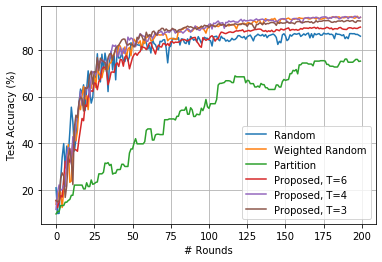

In [16]:
plt.plot(plot_random[0,:], label='Random')
plt.plot(plot_w_random[0,:], label='Weighted Random')
plt.plot(plot_partition[0,:], label='Partition')
plt.plot(plot_Proposed_T6[0,:], label='Proposed, T=6')
plt.plot(plot_Proposed_T4[0,:], label='Proposed, T=4')
plt.plot(plot_Proposed_T3[0,:], label='Proposed, T=3')
# plt.plot(acc_test_arr_Proposed_N40_K8_T2[:], label='proposed, T=2')
# plt.plot(mean_fairness_N120_pdiff_noSelection[3,:], label='proposed, T=4')
# plt.plot(mean_fairness_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('# Rounds')
# plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()

# plt.savefig('./plots/MNIST_nonIID.eps', format='eps',dpi=300)

plt.show()

